In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import scipy.stats as st
import math
import datetime
import missingno as msno
from scipy.stats import norm, skew
from sklearn import metrics
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn import model_selection
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from mlxtend.regressor import StackingCVRegressor

from termcolor import colored

import warnings
warnings.filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)

pd.set_option('display.max_columns', 15)

In [2]:
df = pd.read_csv("data.csv")
df.head()

name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250Nm@ 1500-2500rpm    5.0  
2     12.7@ 2,700(kgm@ rpm)    5.0  
3  22.4 kgm at 1750-2750rpm    5.0  
4     11.5@ 4,500(kgm@ rpm)    5.0

In [3]:
df.shape

(8128, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [5]:
categoric_columns = ["fuel", "transmission", "owner", "seller_type"]
for column in categoric_columns:
    df[column] = df[column].astype("category")

In [6]:
df["car_brand_name"] = df["name"].str.extract('([^\s]+)')
df["car_brand_name"] = df["car_brand_name"].astype("category")

In [7]:
df["engine"] = df["engine"].str.extract('([^\s]+)').astype("float")
df["mileage"] = df["mileage"].str.extract('([^\s]+)').astype("float")

In [8]:
df["max_power"] = df["max_power"].str.extract('([^\s]+)')
df["max_power"] = df["max_power"][~(df["max_power"] == "bhp")]
df["max_power"] = df["max_power"].astype("float")

In [9]:
df["car_age"] = (datetime.datetime.now().year) - (df["year"])

In [10]:
df.drop(["name", "year", "torque"], axis = 1, inplace = True)

In [11]:
df.head()

selling_price  km_driven    fuel seller_type transmission         owner  \
0         450000     145500  Diesel  Individual       Manual   First Owner   
1         370000     120000  Diesel  Individual       Manual  Second Owner   
2         158000     140000  Petrol  Individual       Manual   Third Owner   
3         225000     127000  Diesel  Individual       Manual   First Owner   
4         130000     120000  Petrol  Individual       Manual   First Owner   

   mileage  engine  max_power  seats car_brand_name  car_age  
0    23.40  1248.0      74.00    5.0         Maruti       10  
1    21.14  1498.0     103.52    5.0          Skoda       10  
2    17.70  1497.0      78.00    5.0          Honda       18  
3    23.00  1396.0      90.00    5.0        Hyundai       14  
4    16.10  1298.0      88.20    5.0         Maruti       17

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   selling_price   8128 non-null   int64   
 1   km_driven       8128 non-null   int64   
 2   fuel            8128 non-null   category
 3   seller_type     8128 non-null   category
 4   transmission    8128 non-null   category
 5   owner           8128 non-null   category
 6   mileage         7907 non-null   float64 
 7   engine          7907 non-null   float64 
 8   max_power       7912 non-null   float64 
 9   seats           7907 non-null   float64 
 10  car_brand_name  8128 non-null   category
 11  car_age         8128 non-null   int64   
dtypes: category(5), float64(4), int64(3)
memory usage: 486.3 KB


In [13]:
df.isnull().sum()

selling_price       0
km_driven           0
fuel                0
seller_type         0
transmission        0
owner               0
mileage           221
engine            221
max_power         216
seats             221
car_brand_name      0
car_age             0
dtype: int64

In [14]:
df.describe()

selling_price     km_driven      mileage       engine    max_power  \
count   8.128000e+03  8.128000e+03  7907.000000  7907.000000  7912.000000   
mean    6.382718e+05  6.981951e+04    19.418783  1458.625016    91.517919   
std     8.062534e+05  5.655055e+04     4.037145   503.916303    35.822499   
min     2.999900e+04  1.000000e+00     0.000000   624.000000     0.000000   
25%     2.549990e+05  3.500000e+04    16.780000  1197.000000    68.050000   
50%     4.500000e+05  6.000000e+04    19.300000  1248.000000    82.000000   
75%     6.750000e+05  9.800000e+04    22.320000  1582.000000   102.000000   
max     1.000000e+07  2.360457e+06    42.000000  3604.000000   400.000000   

             seats      car_age  
count  7907.000000  8128.000000  
mean      5.416719    10.195989  
std       0.959588     4.044249  
min       2.000000     4.000000  
25%       5.000000     7.000000  
50%       5.000000     9.000000  
75%       5.000000    13.000000  
max      14.000000    41.000000

In [15]:
df.describe(include = "category").T

count unique          top  freq
fuel            8128      4       Diesel  4402
seller_type     8128      3   Individual  6766
transmission    8128      2       Manual  7078
owner           8128      5  First Owner  5289
car_brand_name  8128     32       Maruti  2448

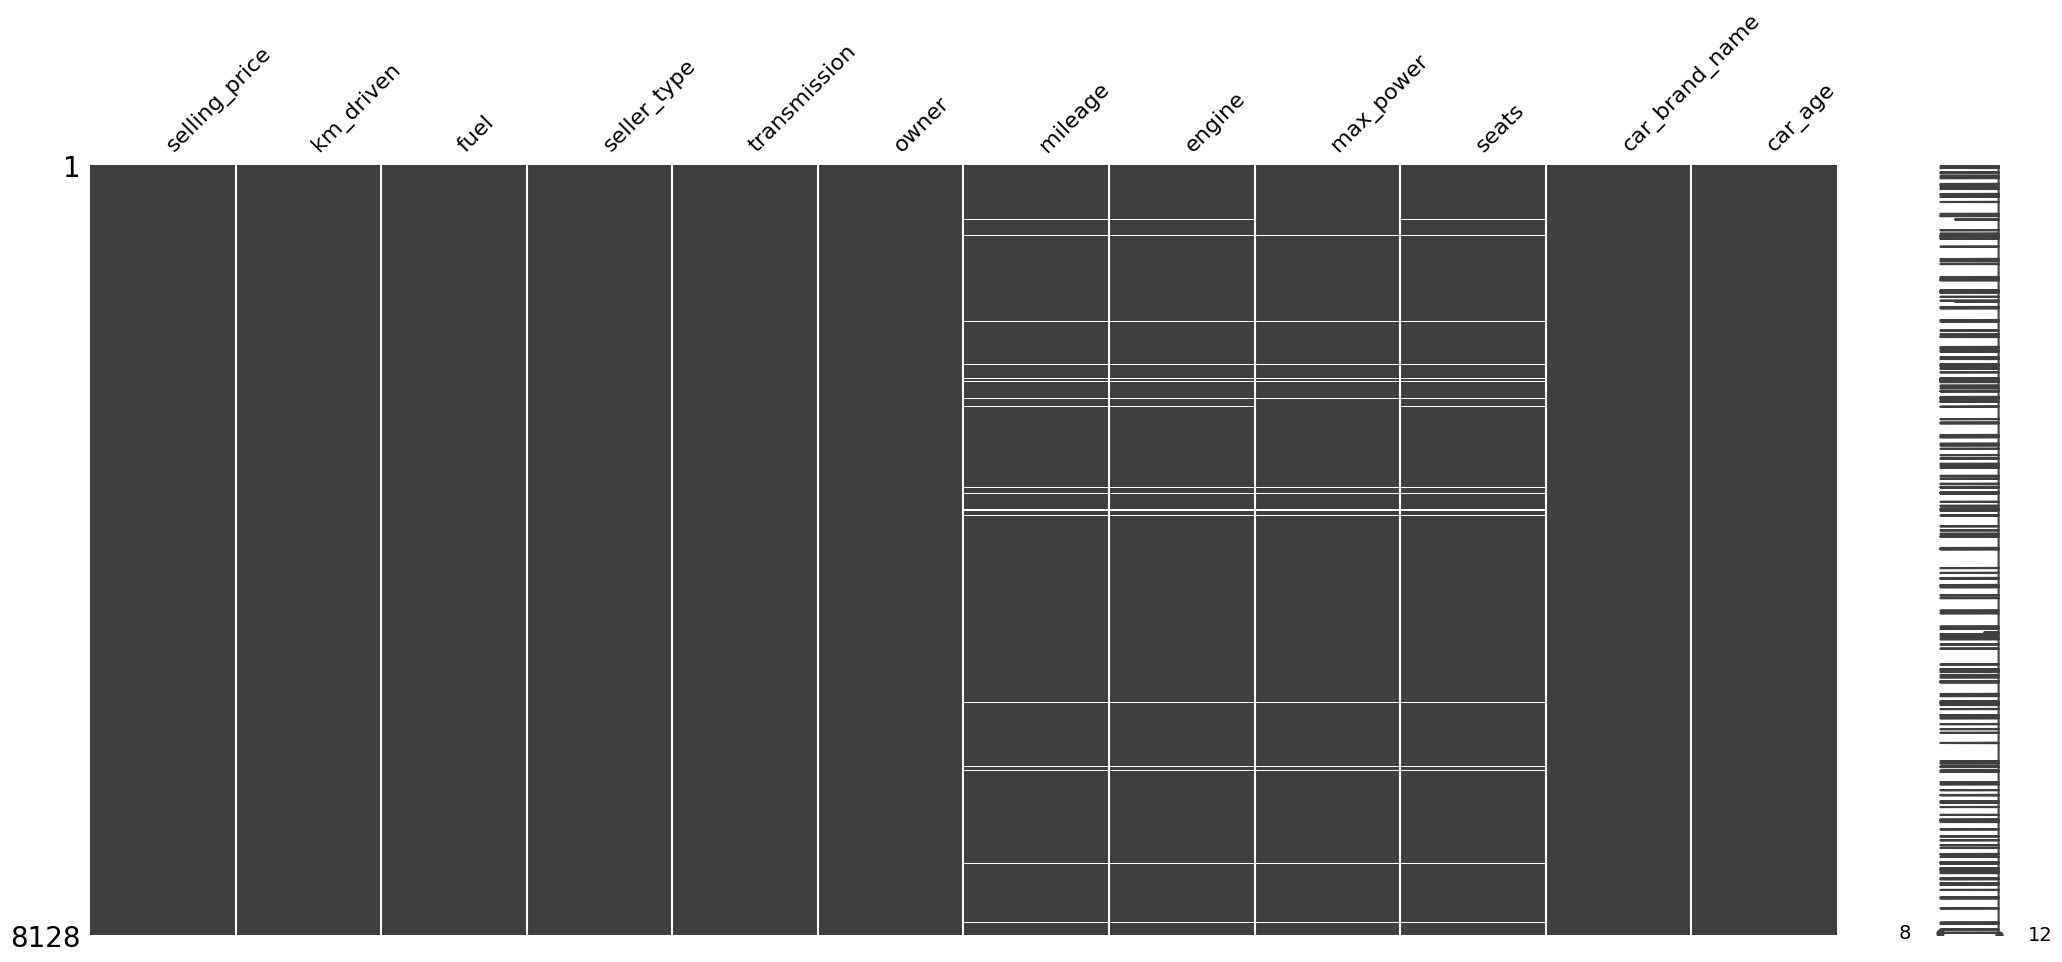

In [16]:
msno.matrix(df);

<Figure size 1000x500 with 0 Axes>

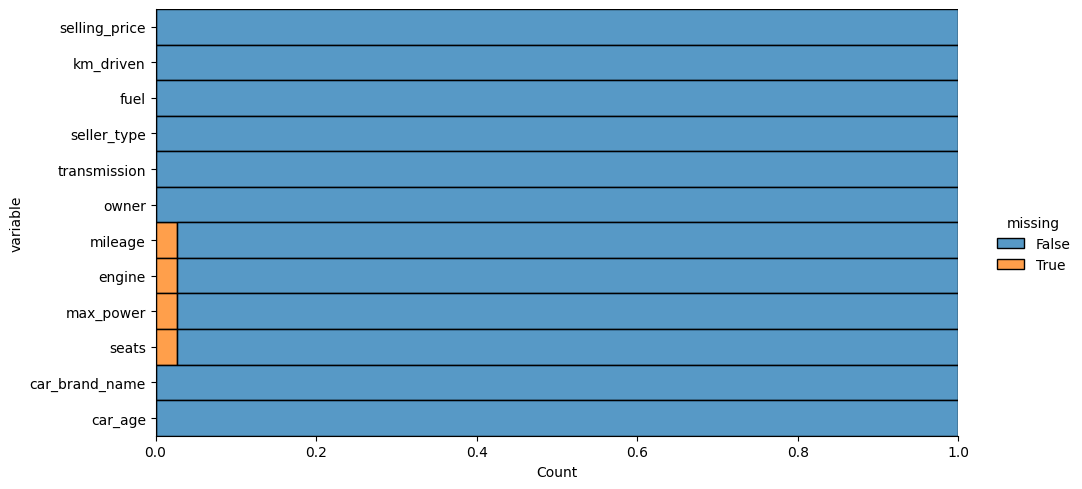

In [17]:
plt.figure(figsize = (10, 5))
sns.displot(
    data = df.isna().melt(value_name = "missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    aspect = 2
);

In [18]:
#fill null values with median (numeric) and frequent values (categoric)

numeric_data = [column for column in df.select_dtypes(["int", "float"])]
categoric_data = [column for column in df.select_dtypes(exclude = ["int", "float"])]

for col in numeric_data:
    df[col].fillna(df[col].median(), inplace = True)
        
#replace missing values in each categorical column with the most frequent value
for col in categoric_data:
    df[col].fillna(df[col].value_counts().index[0], inplace = True)

In [19]:
df.isnull().sum().sum()

0

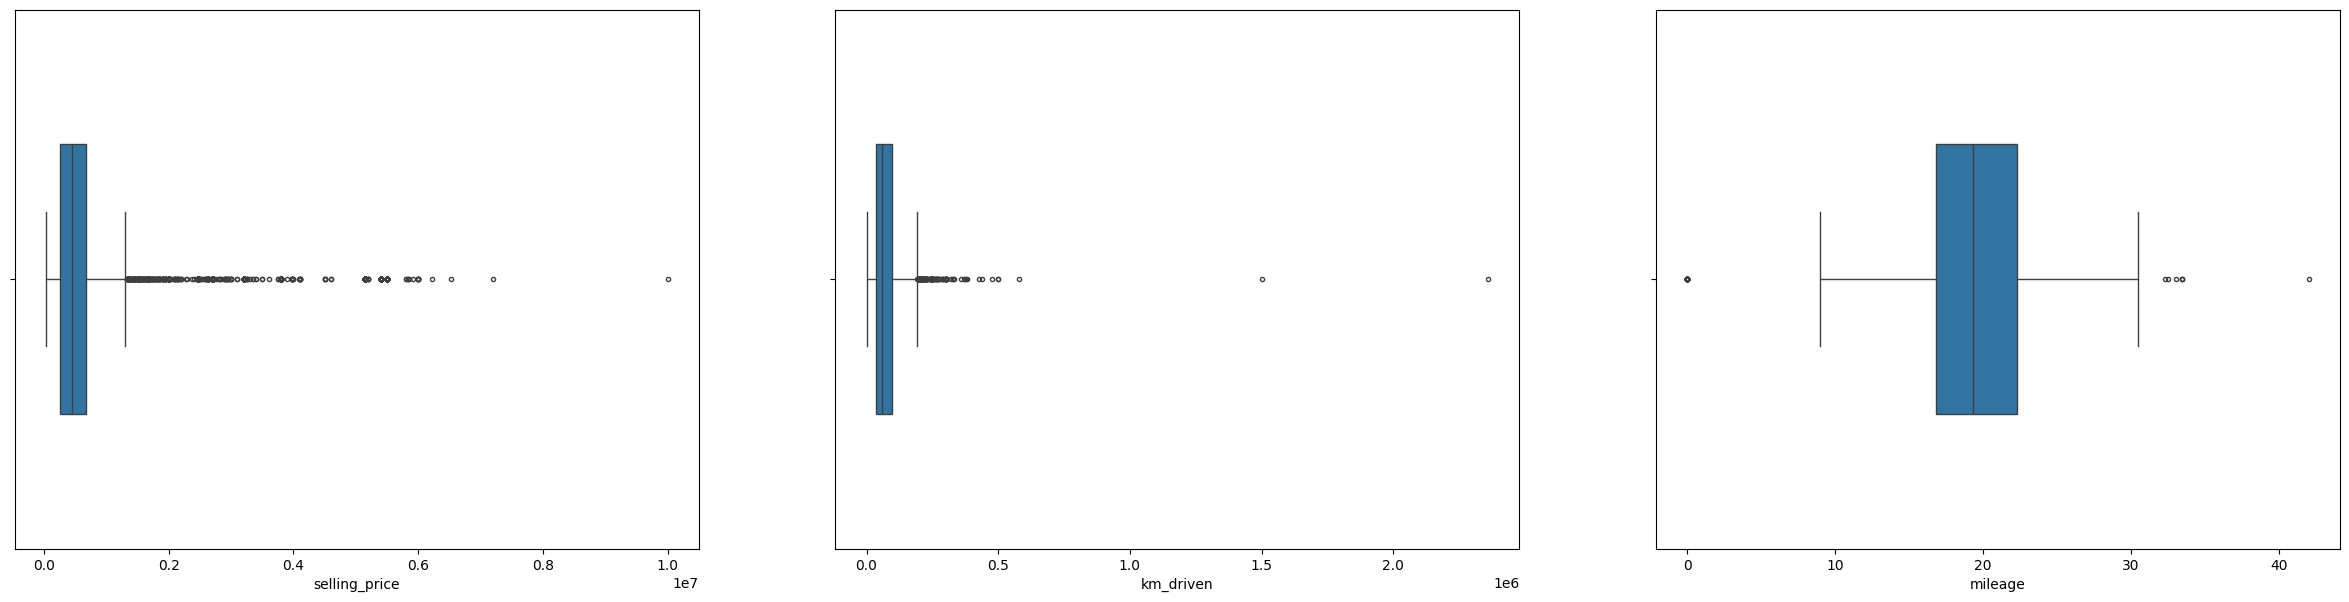

In [21]:
fig, axes = plt.subplots(1, 3, figsize = (30, 7))

sns.boxplot(ax = axes[0], x = "selling_price", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[1], x = "km_driven", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[2], x = "mileage", data = df, width = 0.5, fliersize = 3, linewidth = 1);


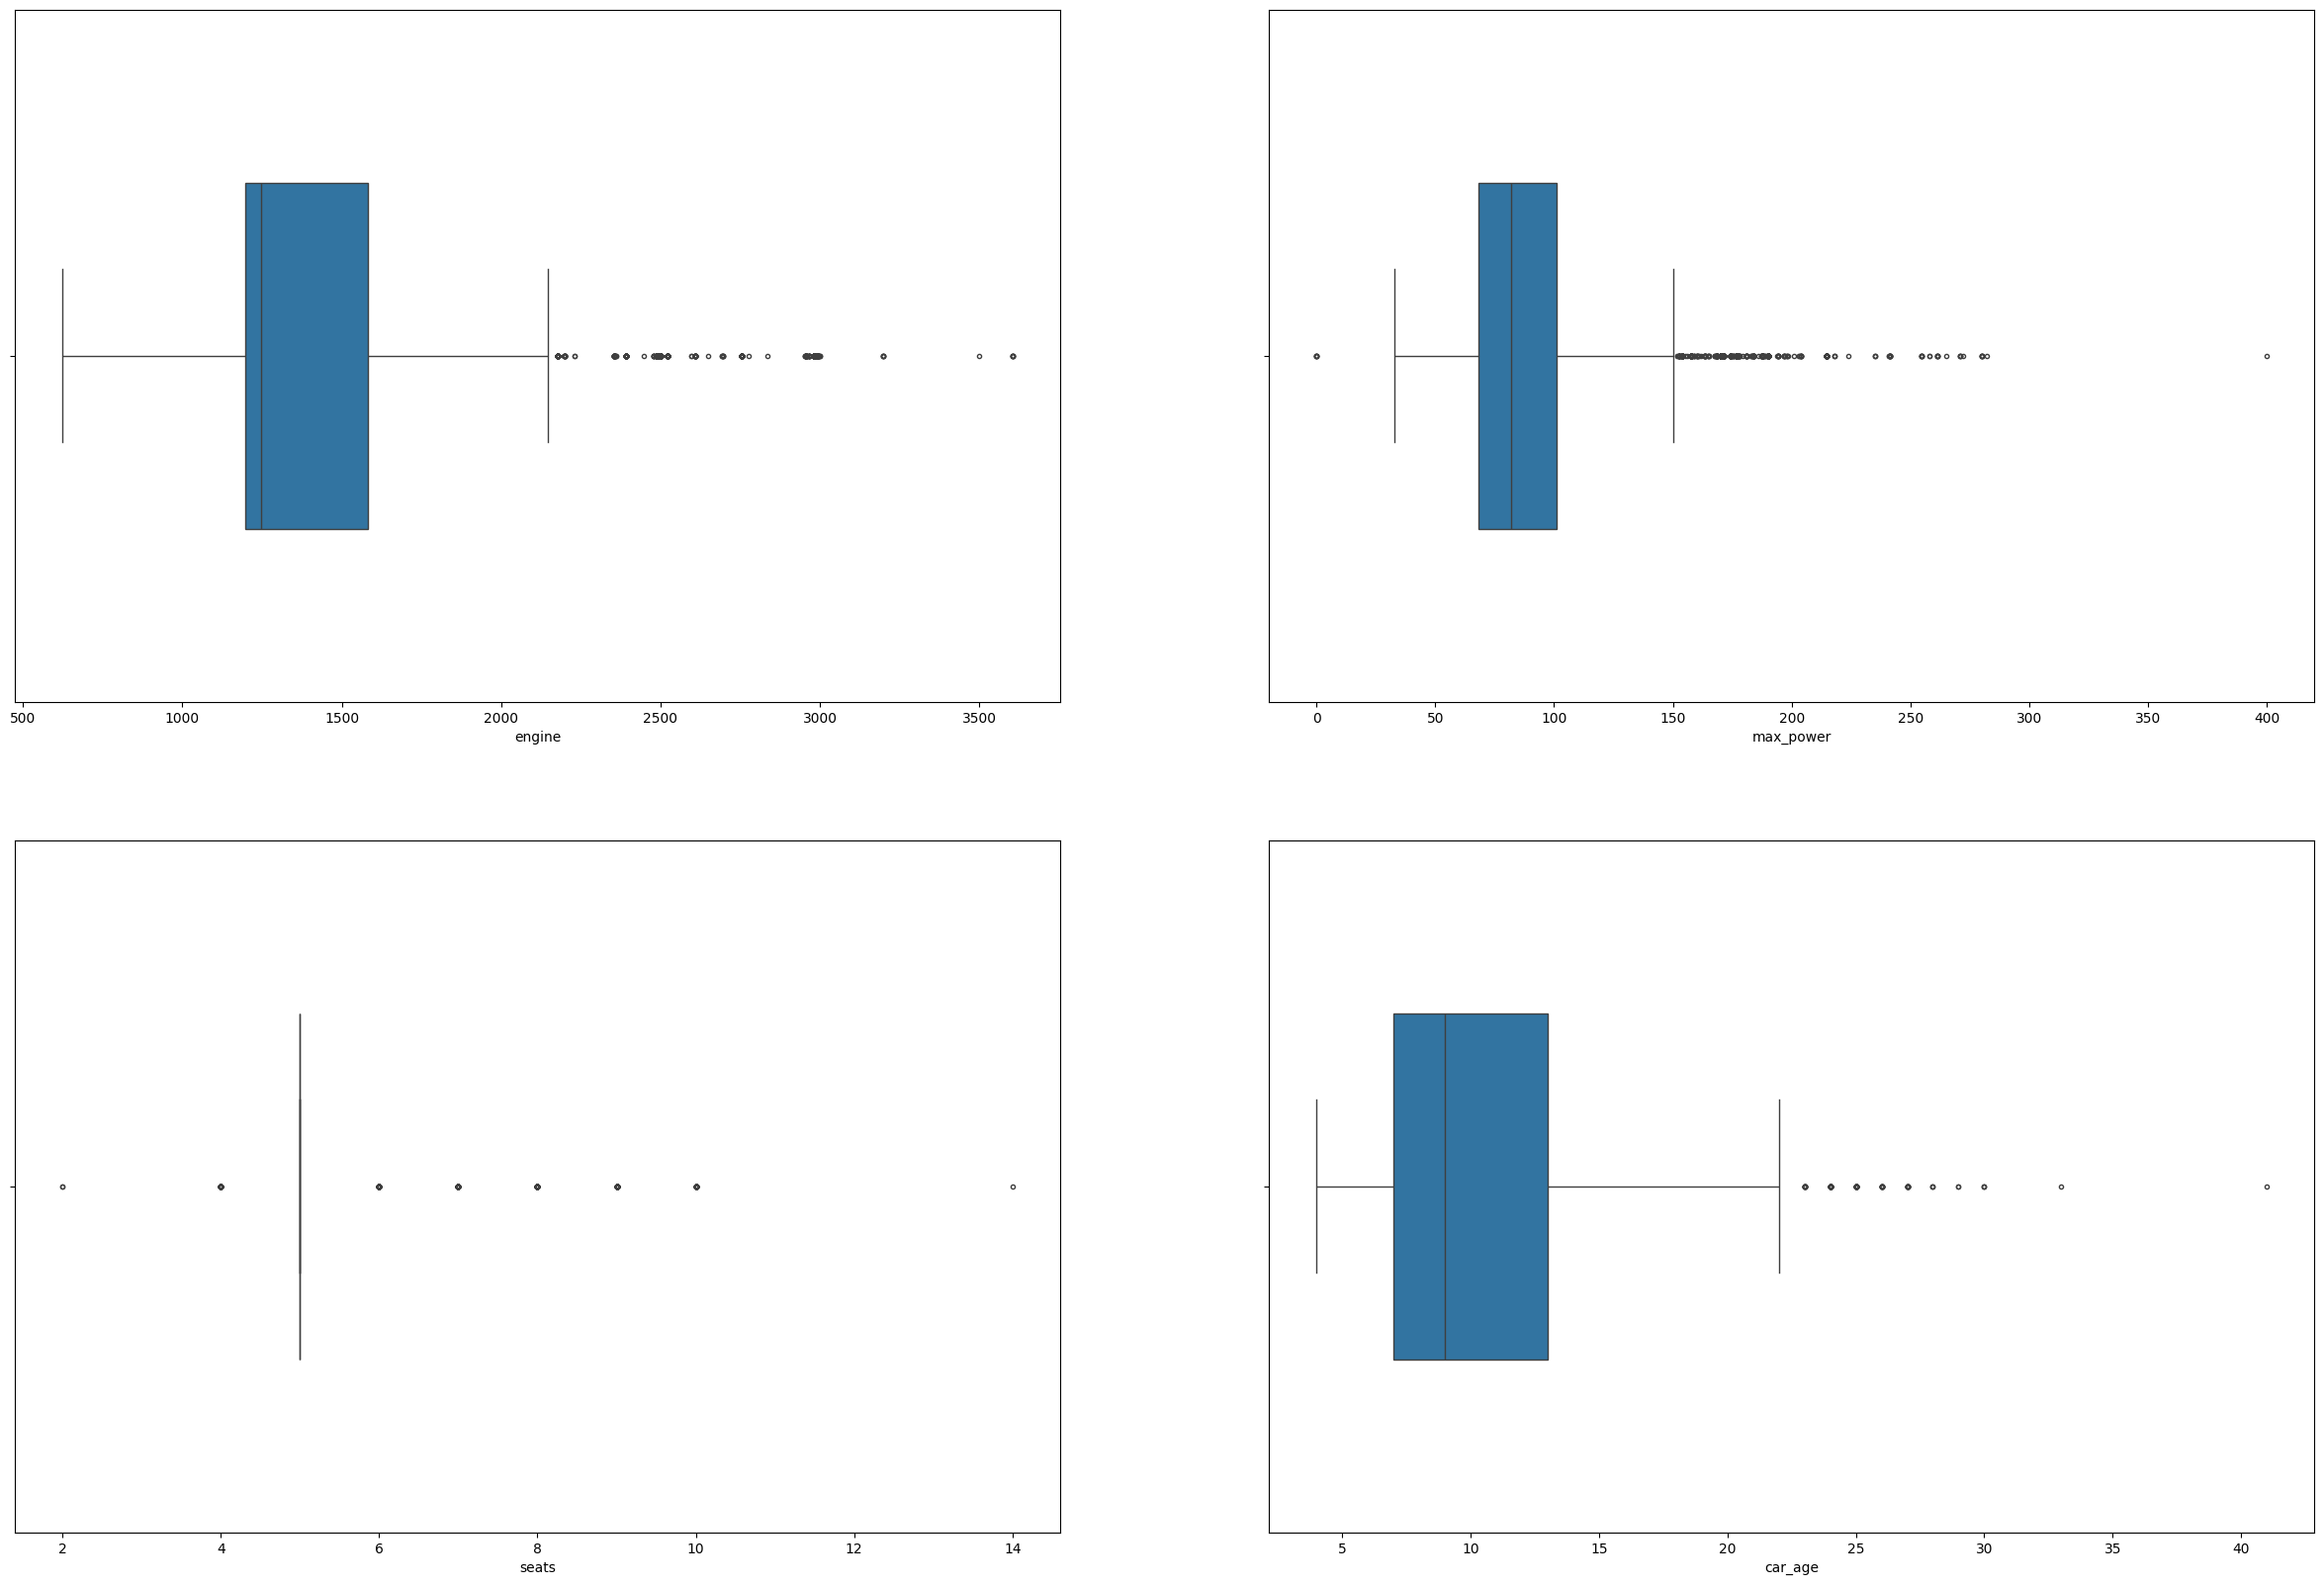

In [22]:
fig, axes = plt.subplots(2, 2, figsize = (30, 20))
axes = axes.flatten()

sns.boxplot(ax = axes[0], x = "engine", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[1], x = "max_power", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[2], x = "seats", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[3], x = "car_age", data = df, width = 0.5, fliersize = 3, linewidth = 1);


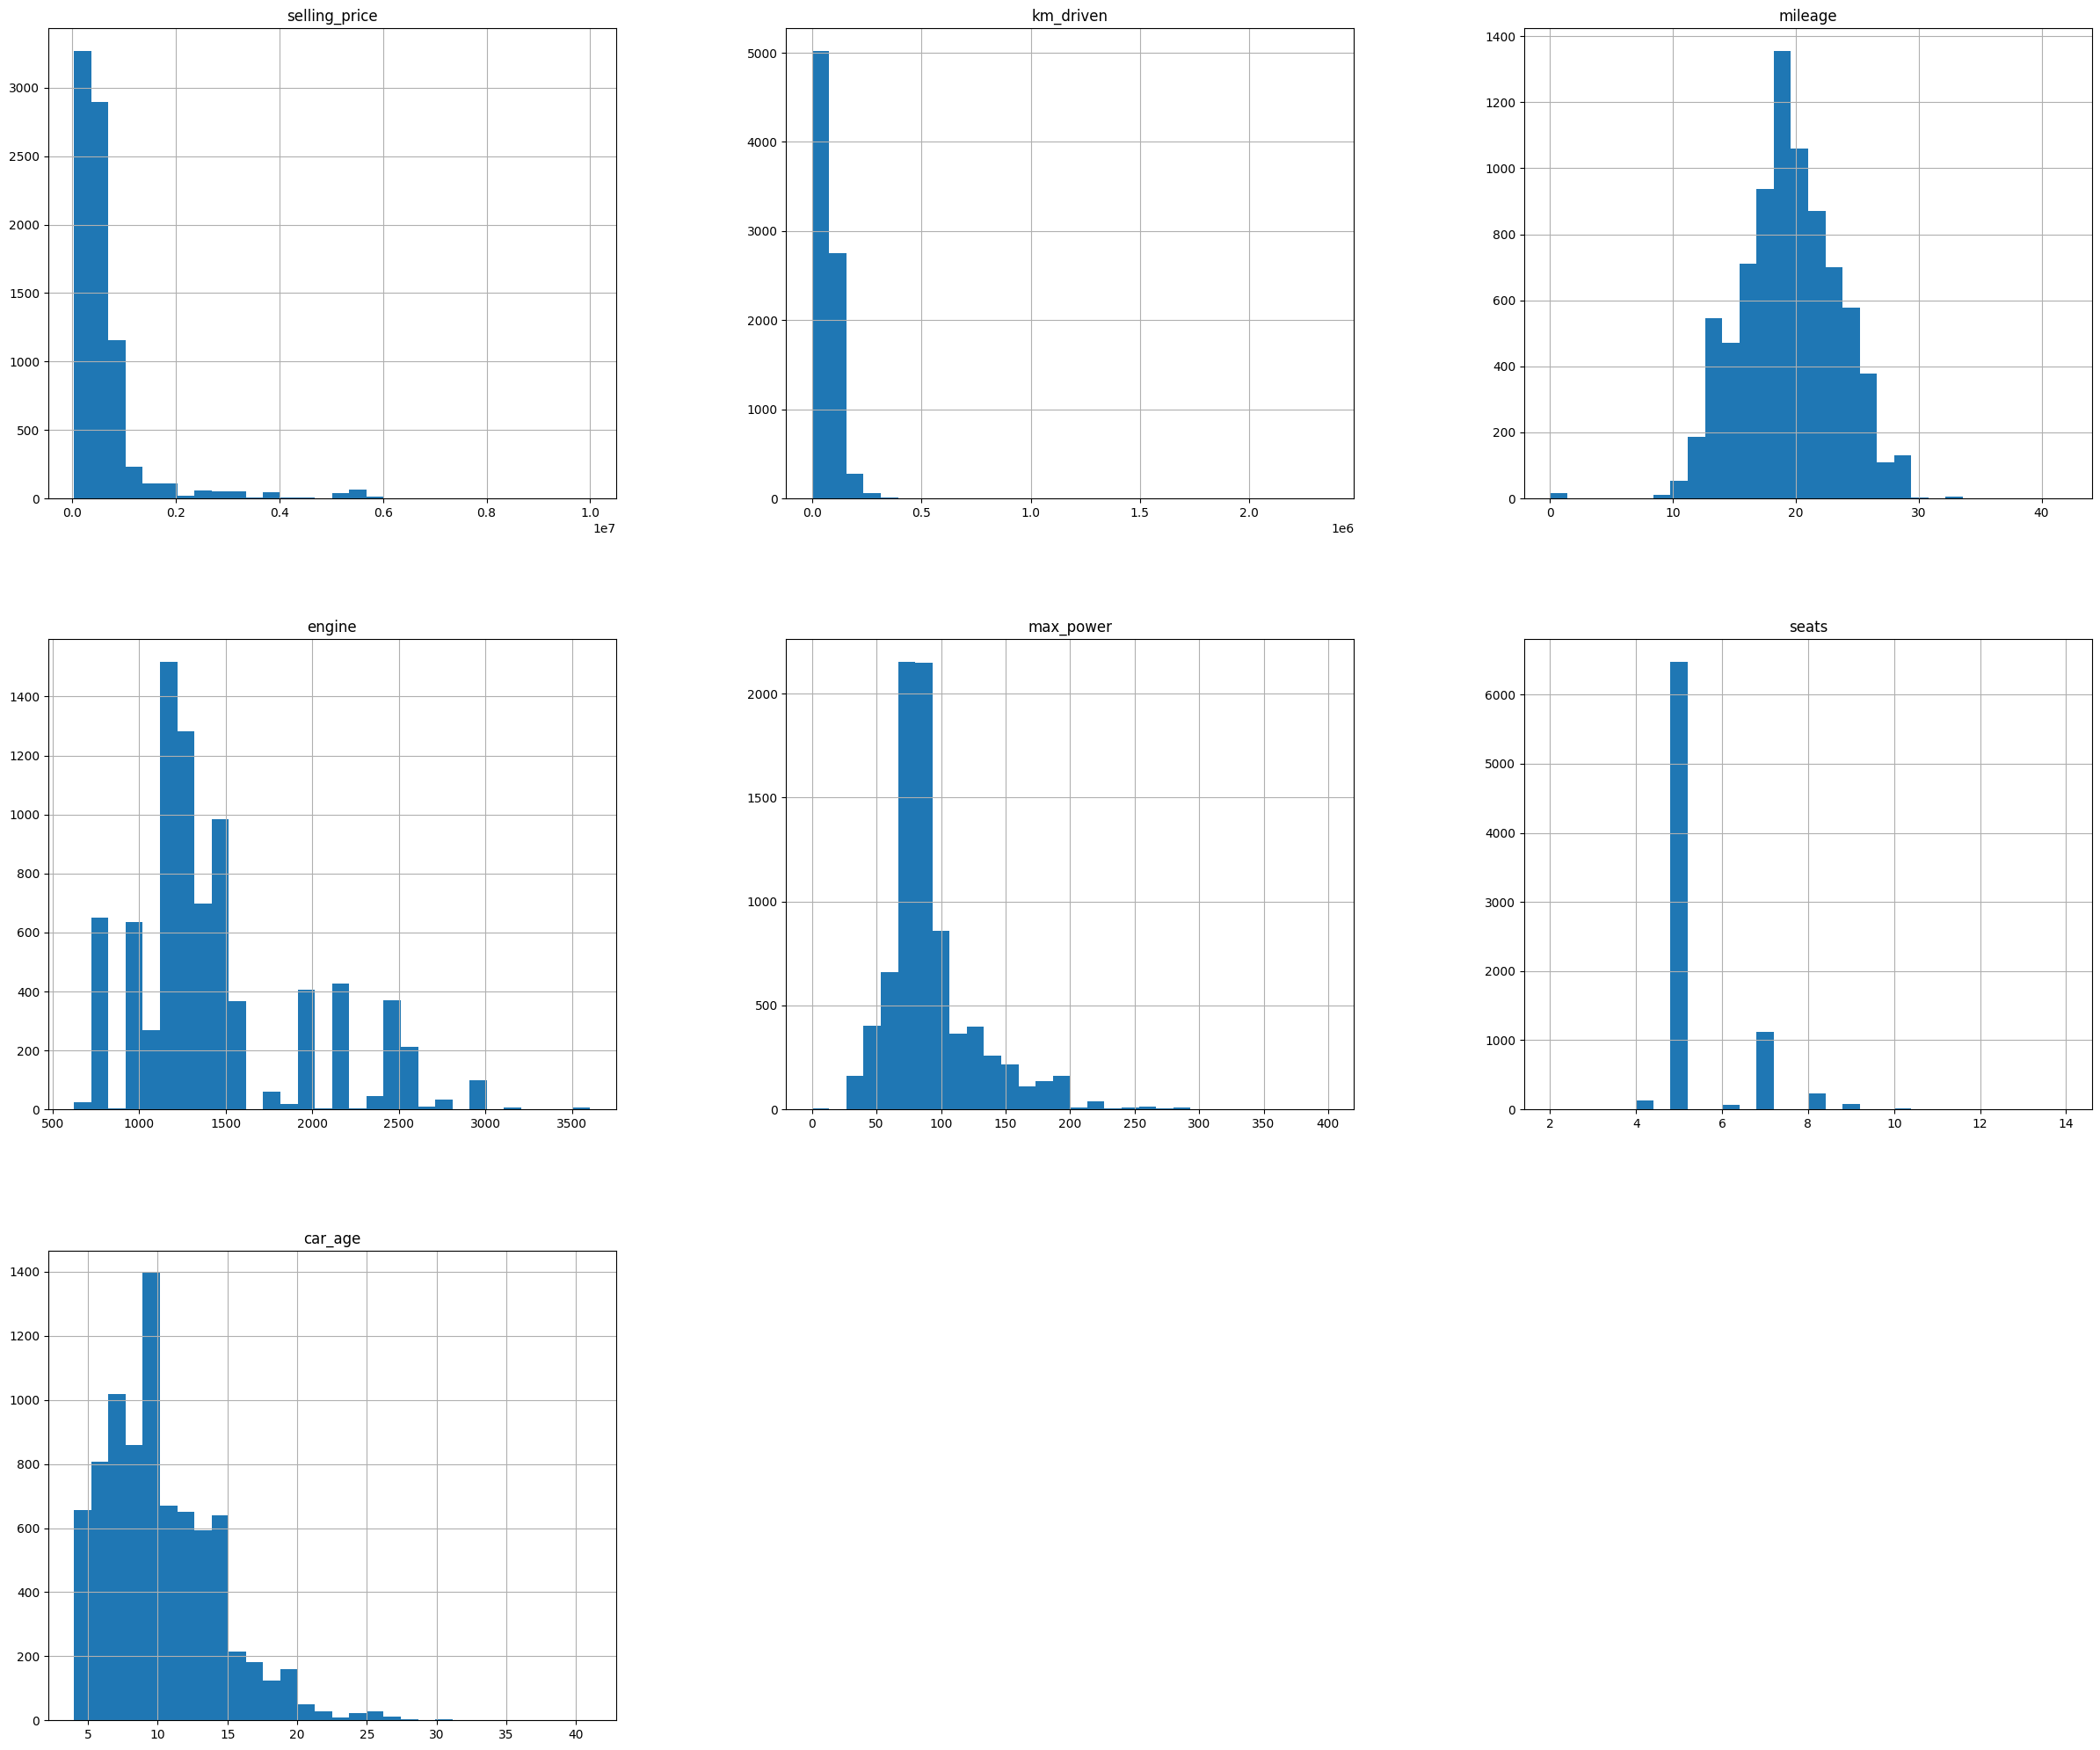

In [23]:
df.hist(figsize = (30, 25), bins = 30, legend = False)
plt.show()

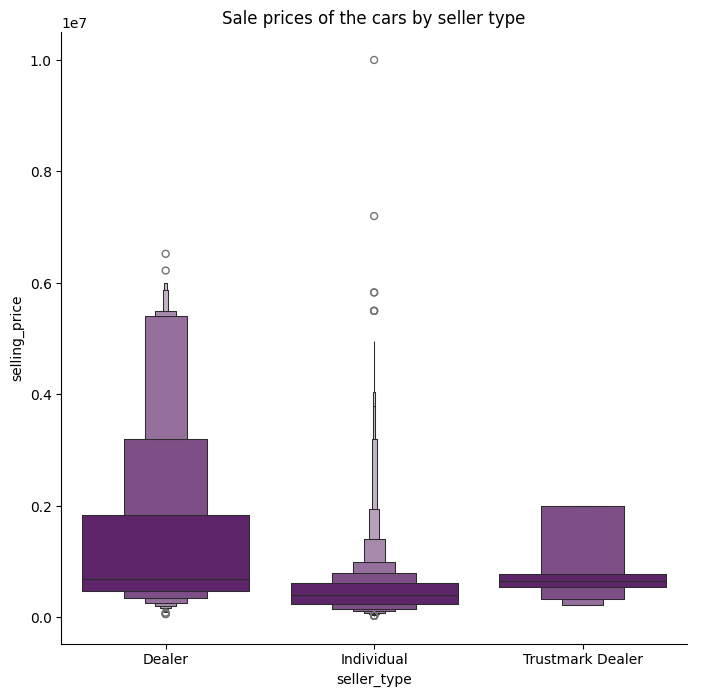

In [24]:
sns.catplot(x = "seller_type",
            y = "selling_price",
            kind = "boxen",
            height = 7,
            aspect = 1,
            color = "#671A76",
            data = df).set(title = "Sale prices of the cars by seller type");

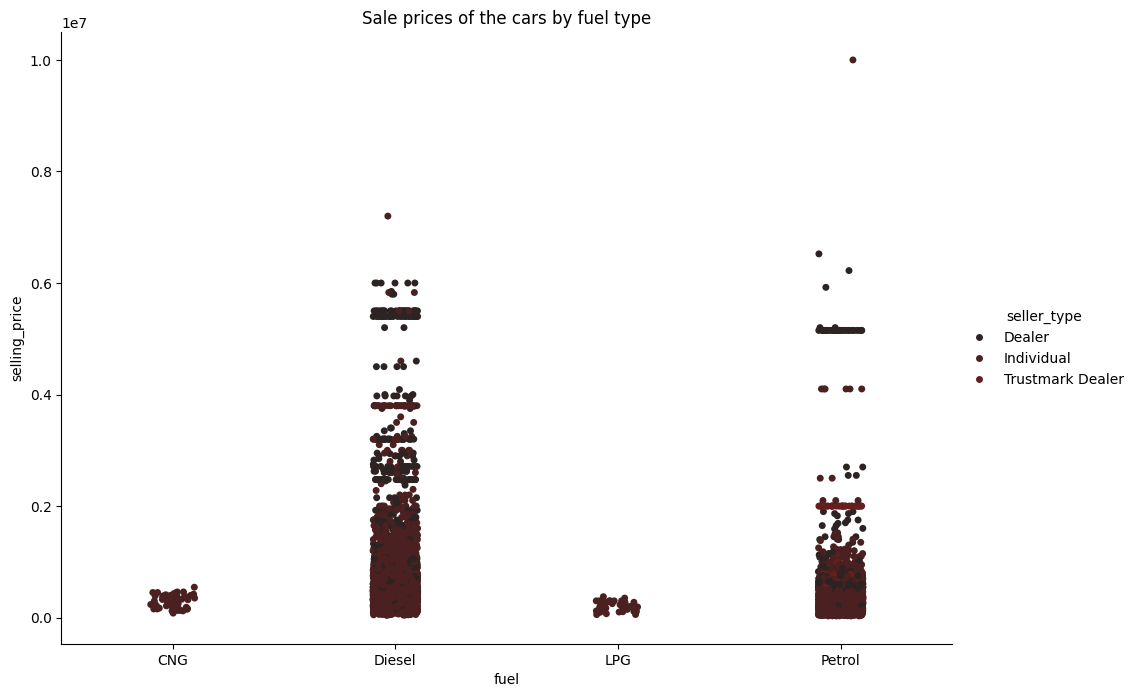

In [25]:
sns.catplot(x = "fuel",
            y = "selling_price",
            kind = "strip",
            hue = "seller_type",
            height = 7,
            aspect = 1.4,
            color = "#661E1D",
            data = df).set(title = "Sale prices of the cars by fuel type");

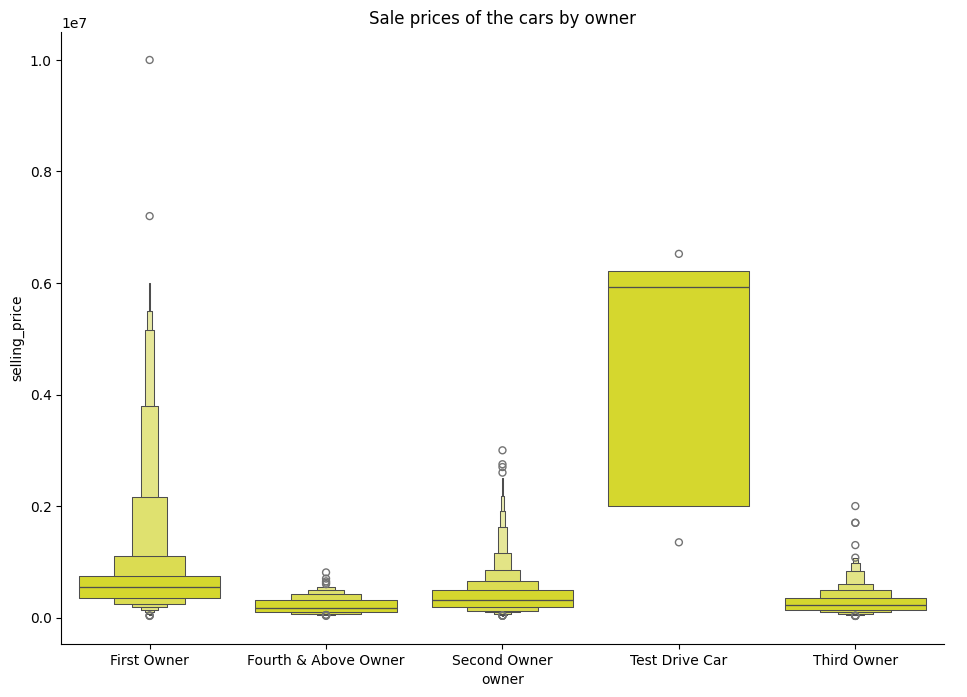

In [26]:
sns.catplot(x = "owner",
            y = "selling_price",
            kind = "boxen",
            height = 7,
            aspect = 1.37,
            color = "#F0F312",
            data = df).set(title = "Sale prices of the cars by owner");

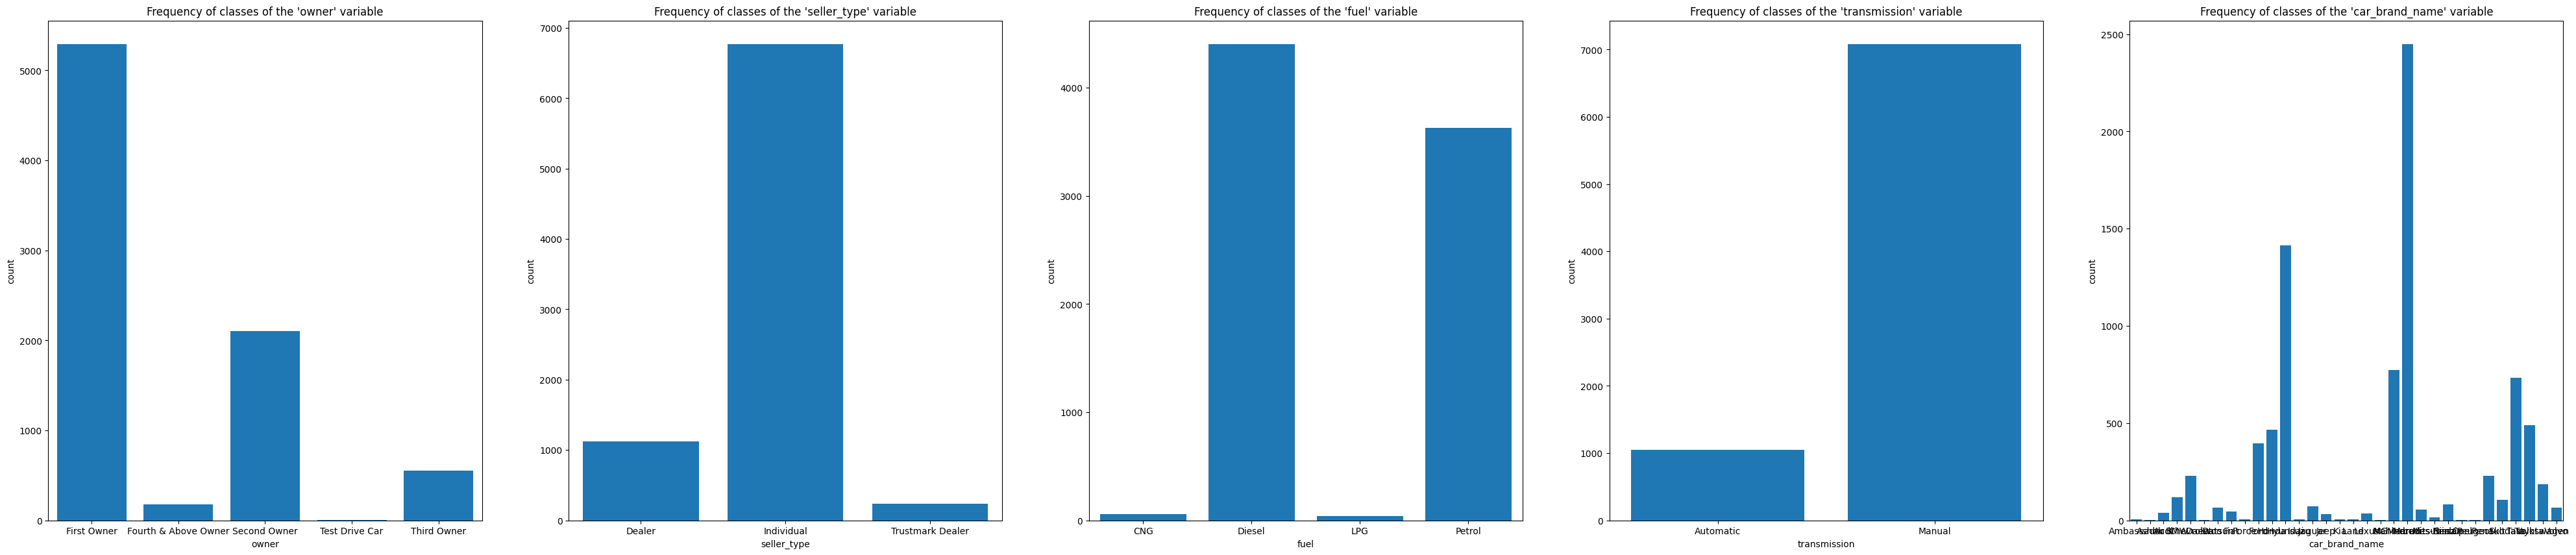

In [28]:
fig, axes = plt.subplots(1, 5, figsize = (50, 10))

sns.barplot(ax = axes[0], x = df["owner"].value_counts().index, y = df["owner"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'owner' variable");

sns.barplot(ax = axes[1], x = df["seller_type"].value_counts().index, y = df["seller_type"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'seller_type' variable");

sns.barplot(ax = axes[2], x = df["fuel"].value_counts().index, y = df["fuel"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'fuel' variable");

sns.barplot(ax = axes[3], x = df["transmission"].value_counts().index, y = df["transmission"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'transmission' variable");

sns.barplot(ax = axes[4], x = df["car_brand_name"].value_counts().index, y = df["car_brand_name"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'car_brand_name' variable");

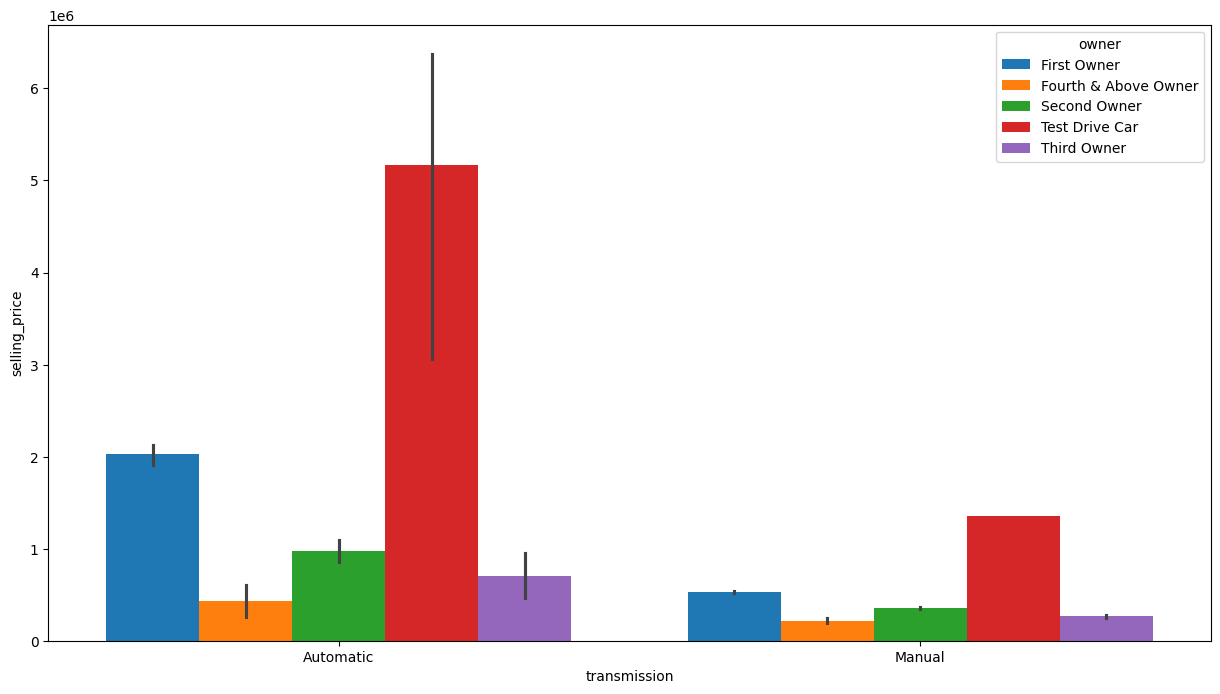

In [29]:
plt.figure(figsize = (15, 8))
sns.barplot(x = "transmission", y = "selling_price", hue = "owner", data = df, saturation = 1);

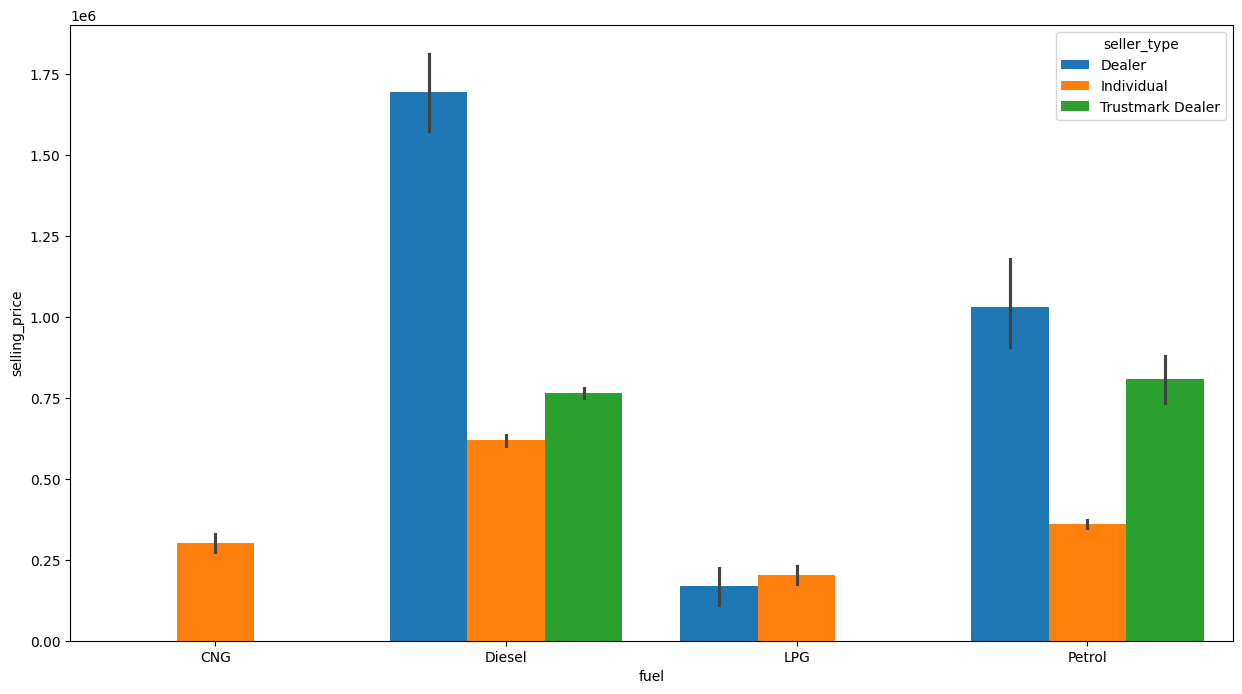

In [30]:
plt.figure(figsize = (15, 8))
sns.barplot(x = "fuel", y = "selling_price", hue = "seller_type", data = df, saturation = 1);

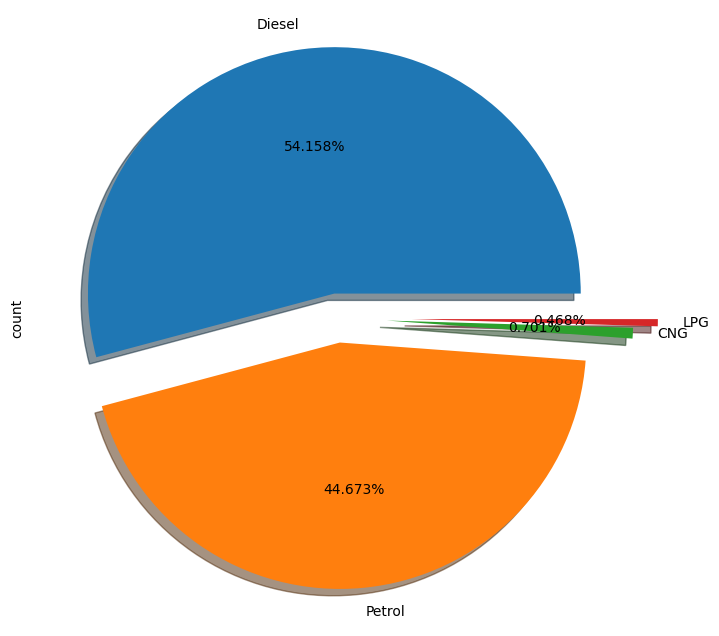

In [31]:
plt.figure(figsize = [8, 8], clear = True, facecolor = "#FFFFFF")
df["fuel"].value_counts().plot.pie(explode = [0.1, 0.1, 0.2, 0.3], autopct='%1.3f%%', shadow = True);

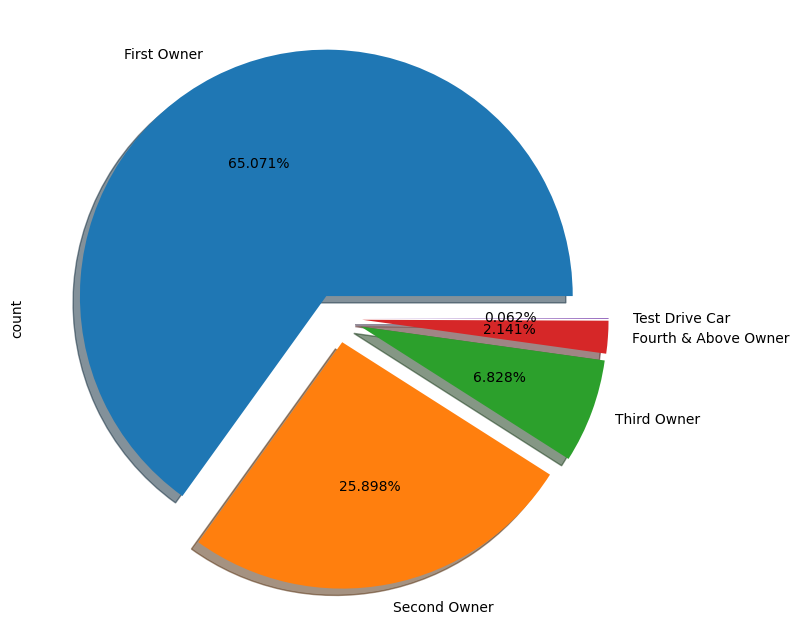

In [32]:
plt.figure(figsize = [8, 8], clear = True, facecolor = "#FFFFFF")
df["owner"].value_counts().plot.pie(explode = [0.1, 0.1, 0.1, 0.1, 0.1], autopct='%1.3f%%', shadow = True);

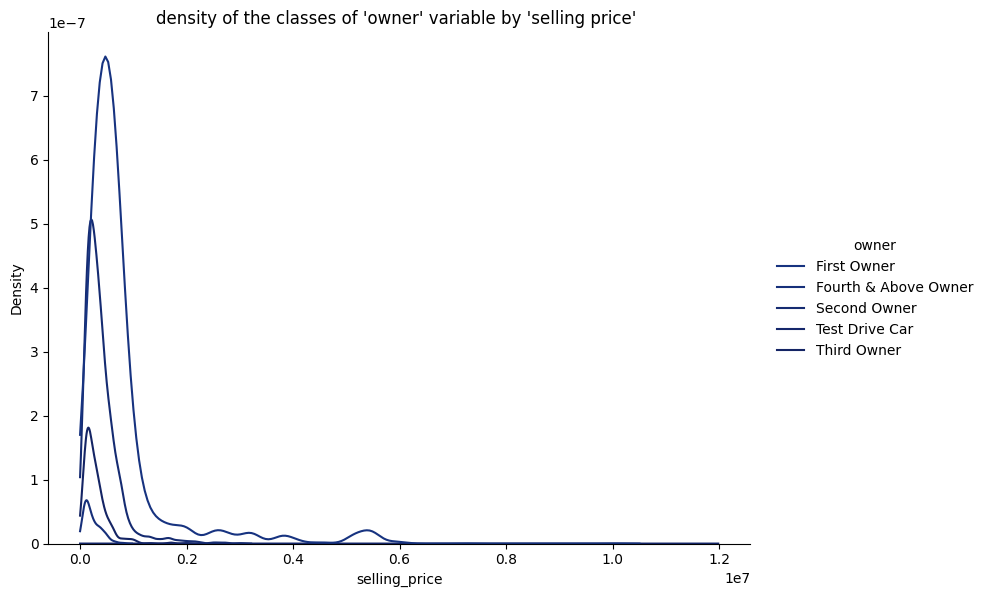

In [33]:
sns.displot(data = df, x = "selling_price", hue = "owner", kind = "kde", height = 6,
            aspect = 1.3, clip=(0, None), palette="ch:rot=-.25, hue = 2, light=.20"
).set(title = "density of the classes of 'owner' variable by 'selling price' ");

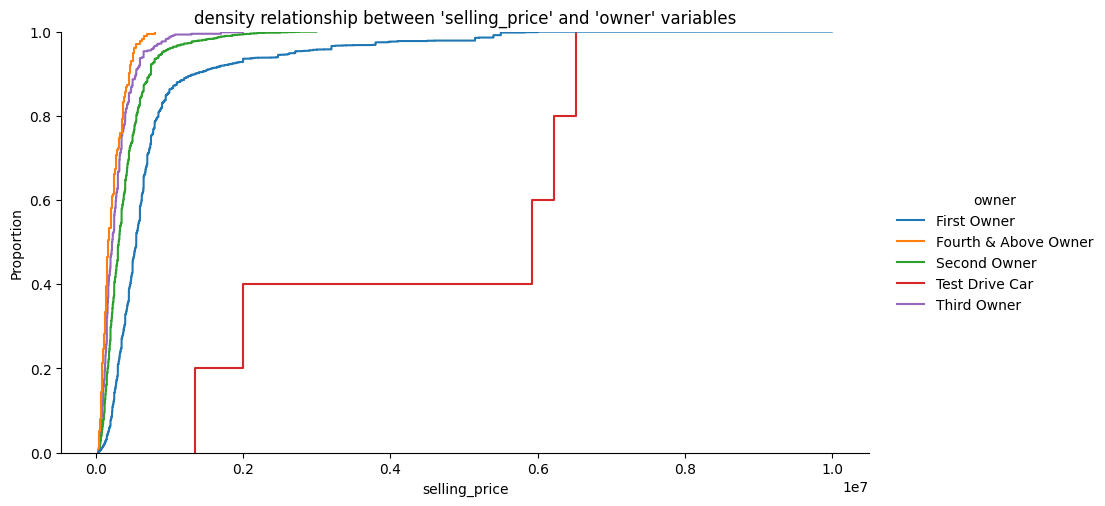

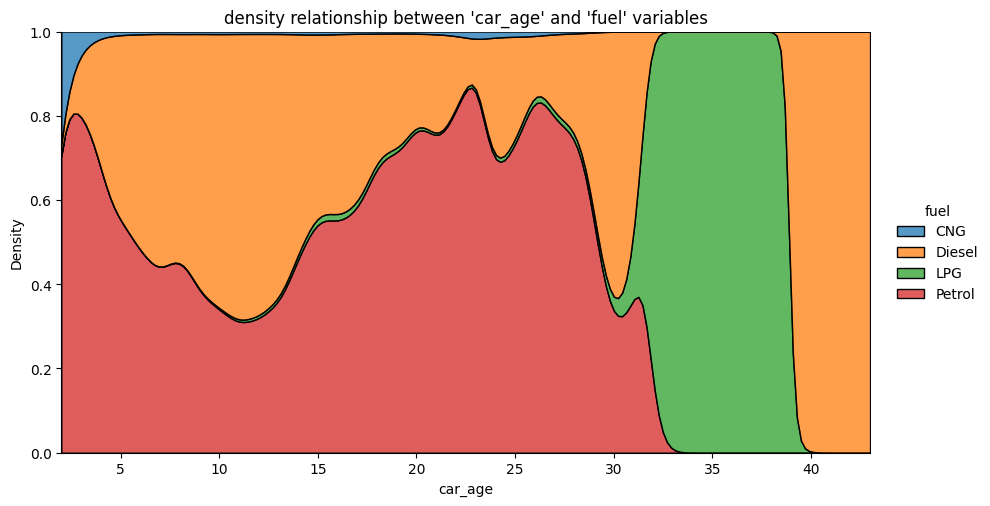

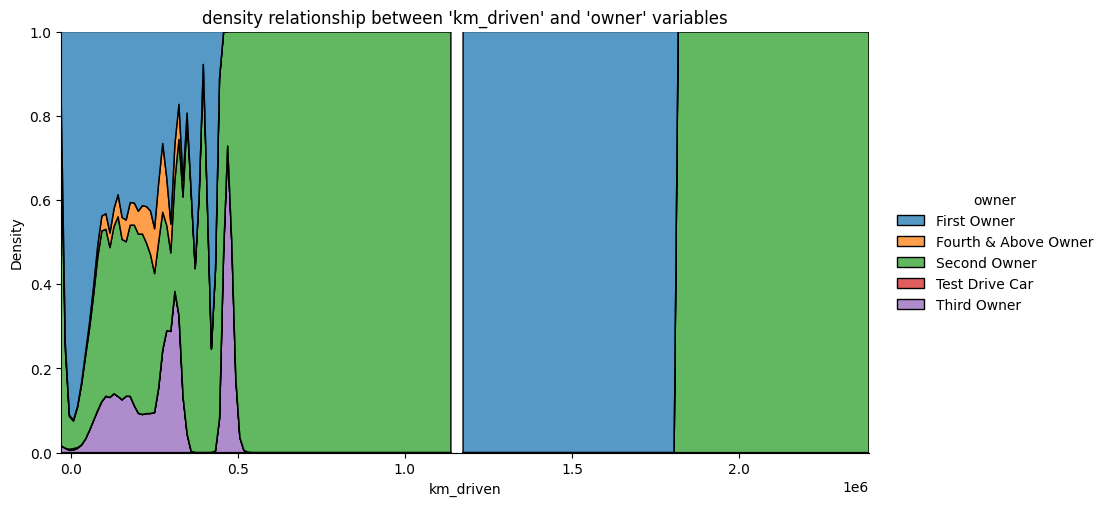

In [34]:
sns.displot(
    data = df, x = "selling_price", hue = "owner",
    kind = "ecdf", height = 5, aspect = 1.8).set(title =  "density relationship between 'selling_price' and 'owner' variables");

sns.displot(
    data = df, x = "car_age", hue = "fuel",
    kind = "kde", height = 5, aspect = 1.8, multiple="fill").set(title = "density relationship between 'car_age' and 'fuel' variables");

sns.displot(
    data = df, x = "km_driven", hue = "owner",
    kind = "kde", height = 5, aspect = 1.8, multiple="fill").set(title = "density relationship between 'km_driven' and 'owner' variables");

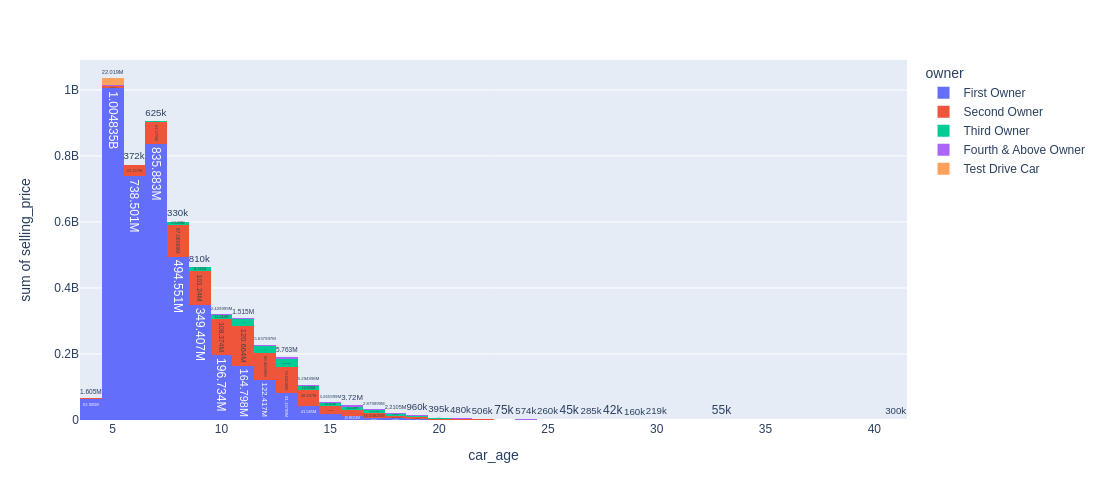

In [35]:
fig = px.histogram(df, x = "car_age",
                   y = "selling_price",
                   marginal = None, text_auto = True,
                   color = "owner", hover_data  = df.columns, width = 850, height = 500)
fig.show()

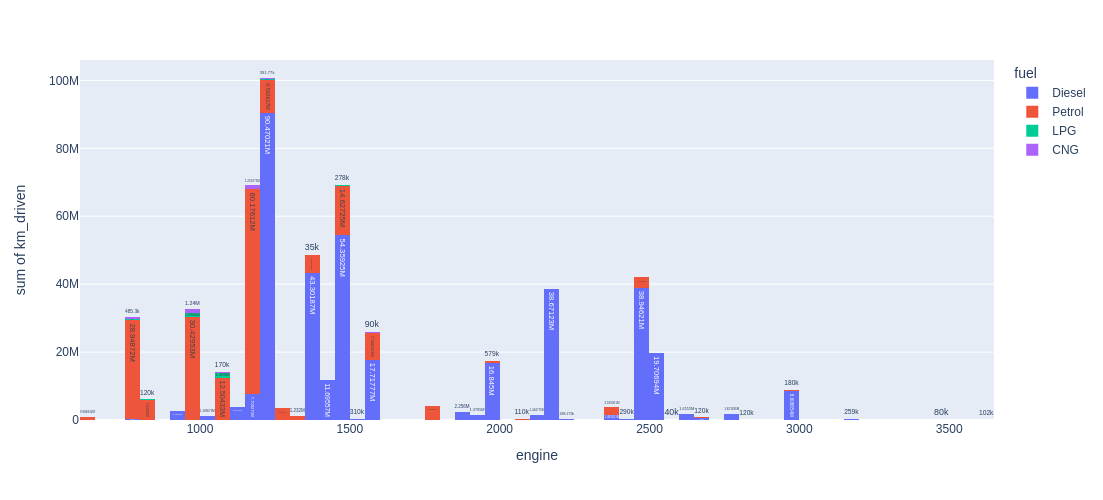

In [36]:
fig = px.histogram(df, x = "engine",
                   y = "km_driven",
                   marginal = None, text_auto = True,
                   color = "fuel", hover_data  = df.columns, width = 850, height = 500)
fig.show()

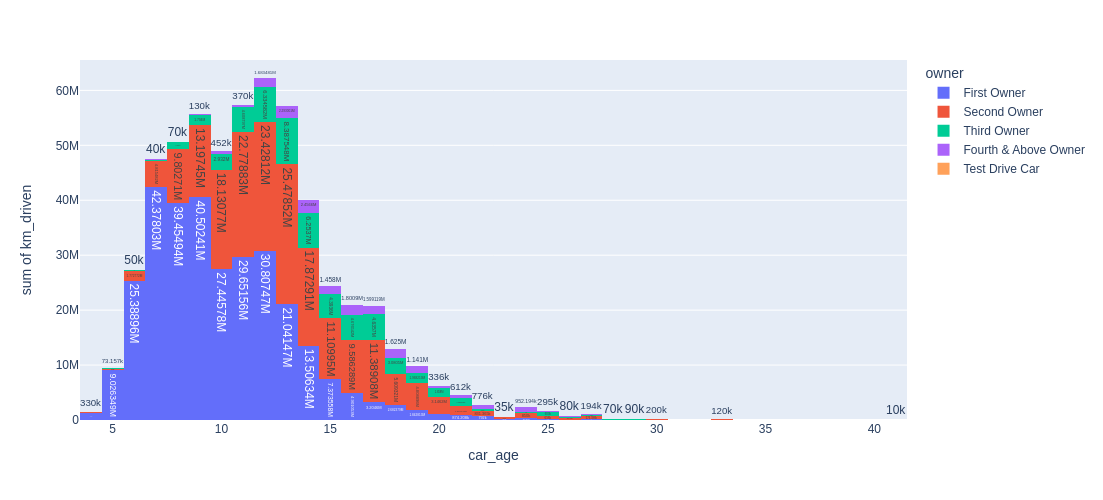

In [37]:
fig = px.histogram(df, x = "car_age",
                   y = "km_driven",
                   marginal = None, text_auto = True,
                   color = "owner", hover_data  = df.columns, width = 850, height = 500)
fig.show()

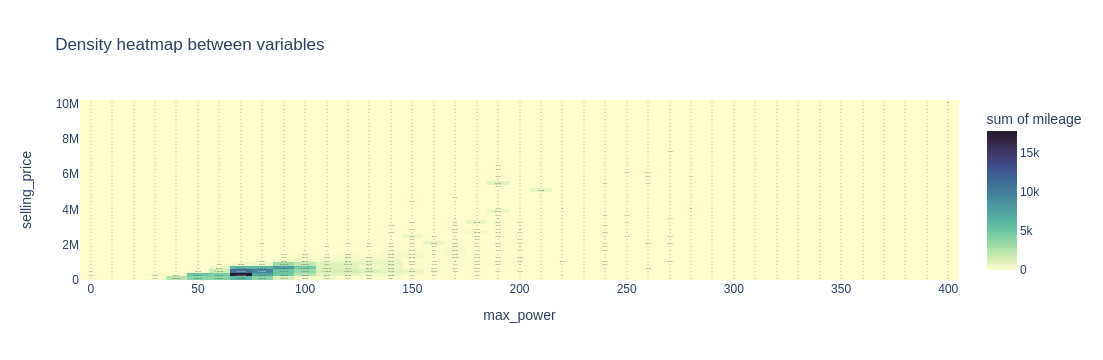

In [38]:
fig = px.density_heatmap(df, x = "max_power", y = "selling_price", z = "mileage",
                        color_continuous_scale = "deep", text_auto = True,
                        title = "Density heatmap between variables")
fig.show()

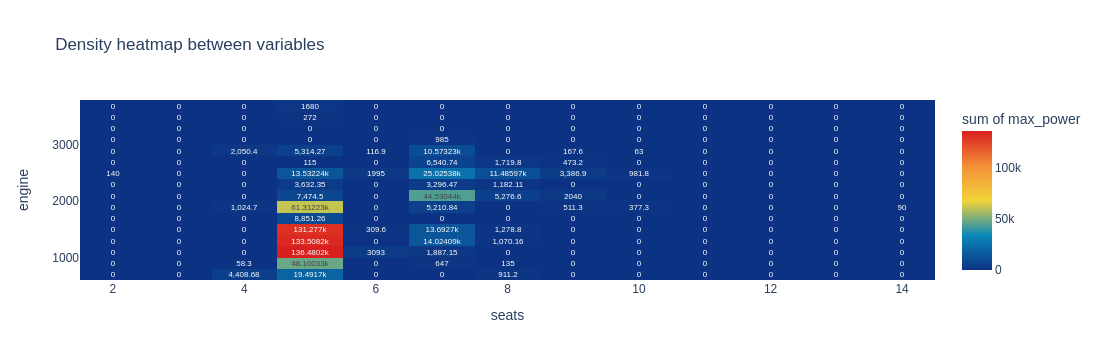

In [39]:
fig = px.density_heatmap(df, x = "seats", y = "engine", z = "max_power", color_continuous_scale = "portland",
                         text_auto = True, title = "Density heatmap between variables")
fig.show()

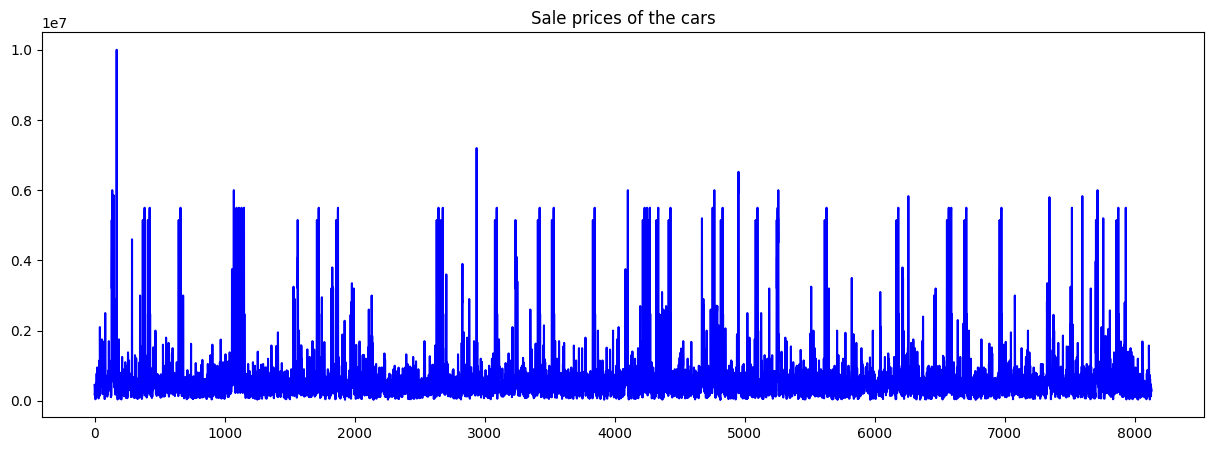

In [40]:
fig, ax = plt.subplots(figsize = (15, 5))
sale_price = list()
for sp in df["selling_price"].values:
    sale_price.append(sp)
sale_price = pd.Series(sale_price)
sale_price.plot(kind = "line", colormap = "winter").set_title("Sale prices of the cars");


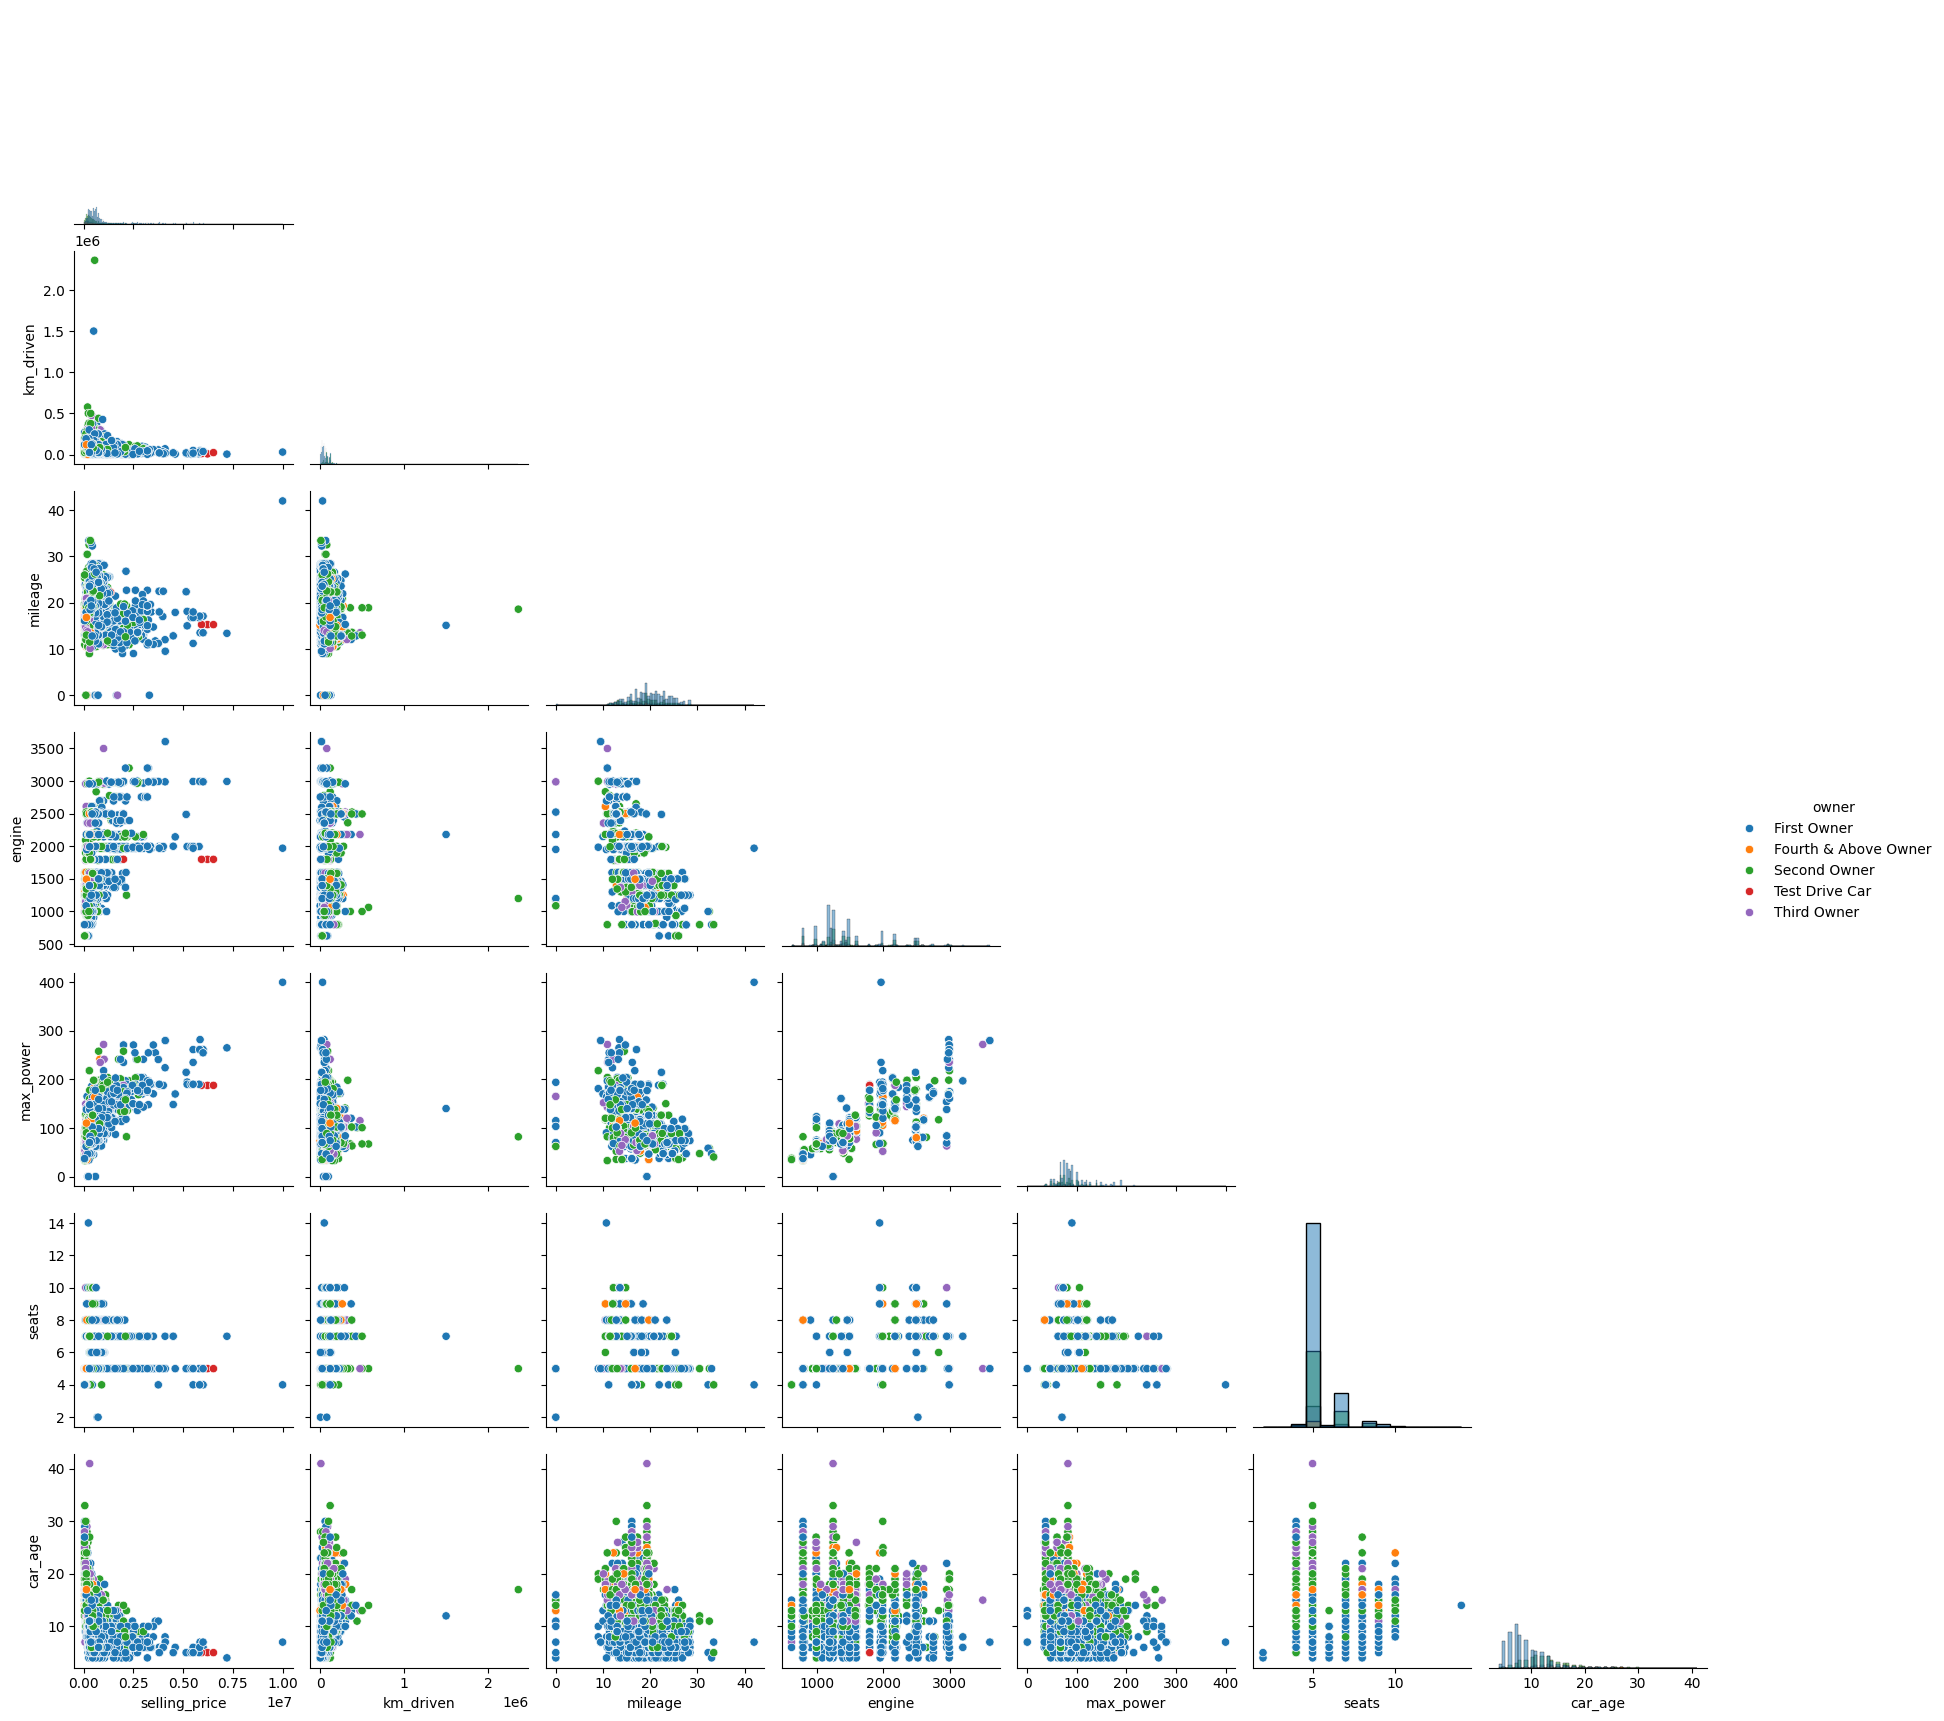

In [41]:
sns.pairplot(df, hue = "owner", diag_kind = "hist", corner = True);

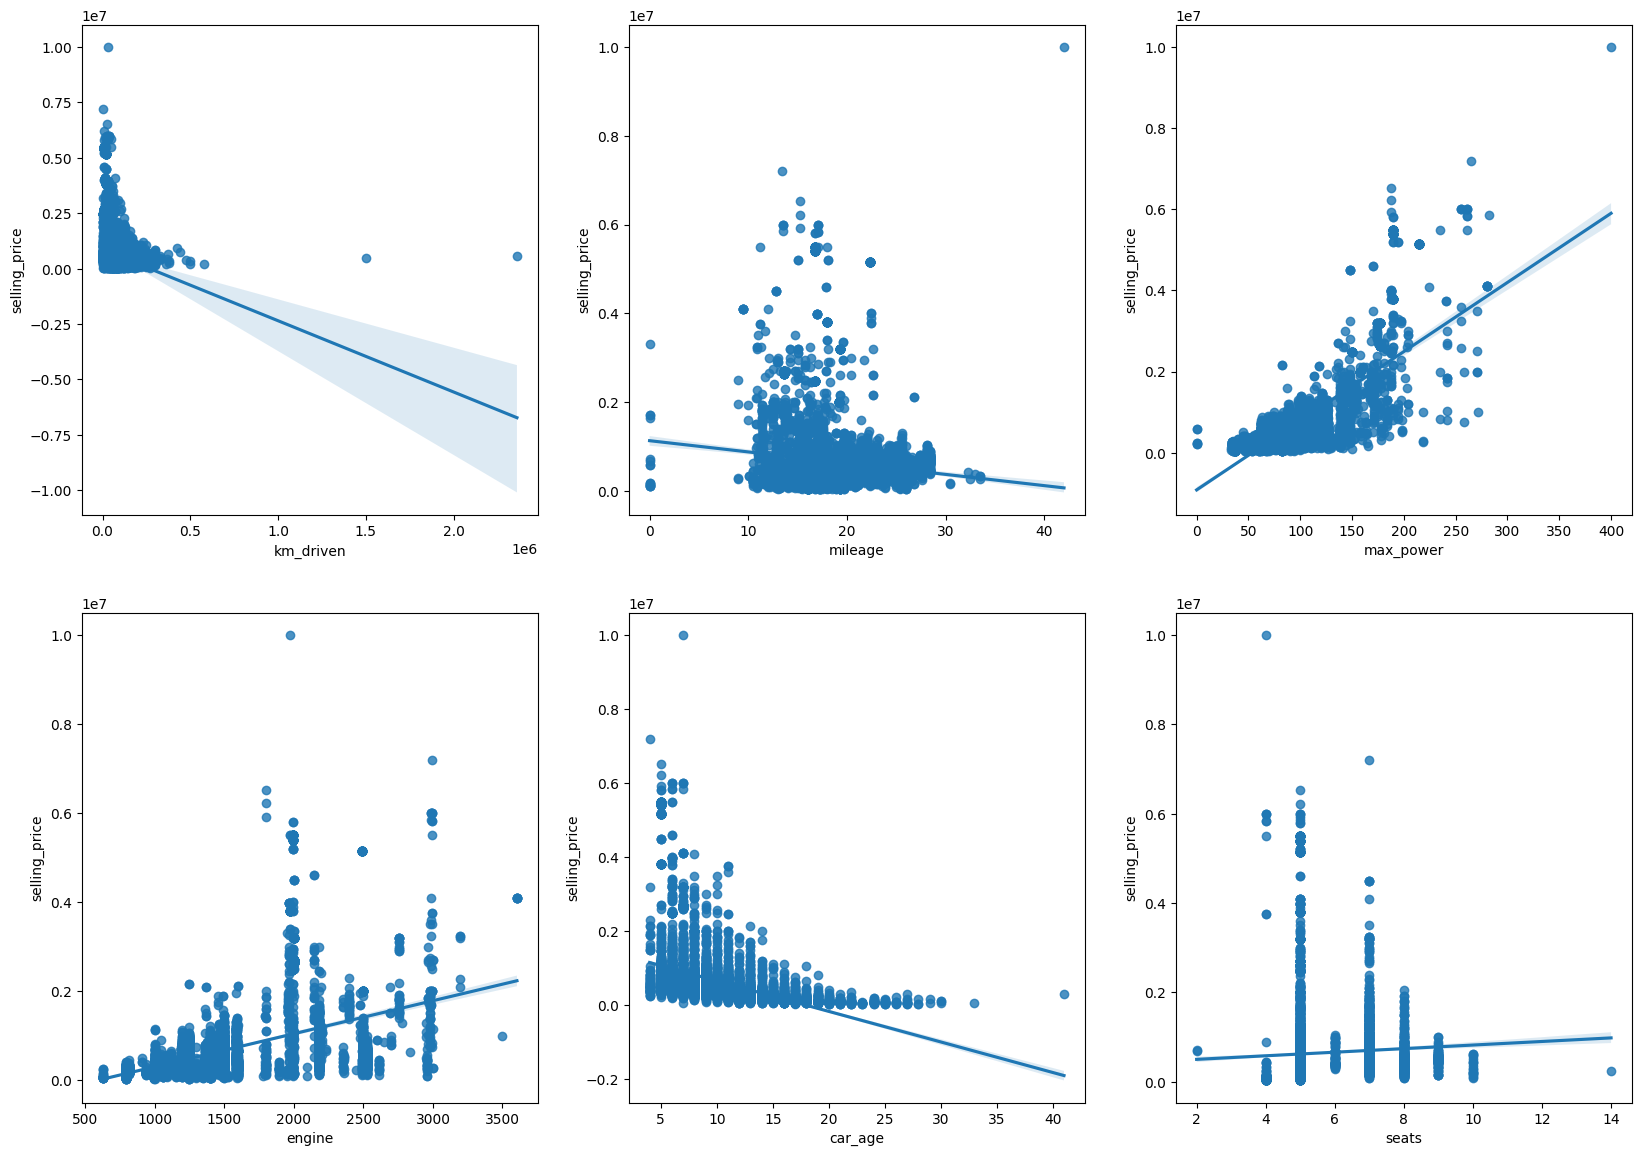

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

sns.regplot(ax = axes[0], x = "km_driven", y = "selling_price", data = df);
sns.regplot(ax = axes[1], x = "mileage", y = "selling_price", data = df);
sns.regplot(ax = axes[2], x = "max_power", y = "selling_price", data = df);
sns.regplot(ax = axes[3], x = "engine", y = "selling_price", data = df);
sns.regplot(ax = axes[4], x = "car_age", y = "selling_price", data = df);
sns.regplot(ax = axes[5], x = "seats", y = "selling_price", data = df);

In [45]:
print("Basic descriptive statistics of the target variable - 'selling_price': \n\n",
      df["selling_price"].describe())

Basic descriptive statistics of the target variable - 'selling_price': 

 count    8.128000e+03
mean     6.382718e+05
std      8.062534e+05
min      2.999900e+04
25%      2.549990e+05
50%      4.500000e+05
75%      6.750000e+05
max      1.000000e+07
Name: selling_price, dtype: float64


In [46]:
print("Skewness of target variable: ", df["selling_price"].skew())
print("Kurtosis of target variable: ", df["selling_price"].kurt())

Skewness of target variable:  4.193533440675855
Kurtosis of target variable:  21.081289012186755


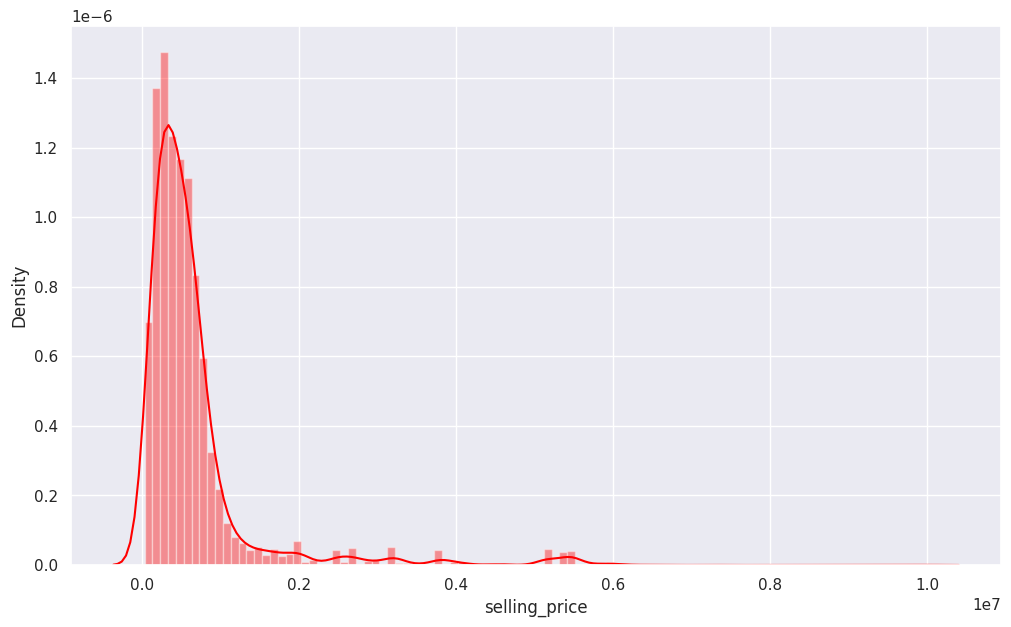

In [47]:
sns.set(rc = {"figure.figsize" : (12, 7)})
sns.distplot(df["selling_price"], bins = 100, color = "red");

In [48]:
df["selling_price"] = np.log1p(df["selling_price"])
df["selling_price"].head(n = 10)

0    13.017005
1    12.821261
2    11.970357
3    12.323860
4    11.775297
5    12.994532
6    11.472114
7    10.714440
8    12.765691
9    12.206078
Name: selling_price, dtype: float64

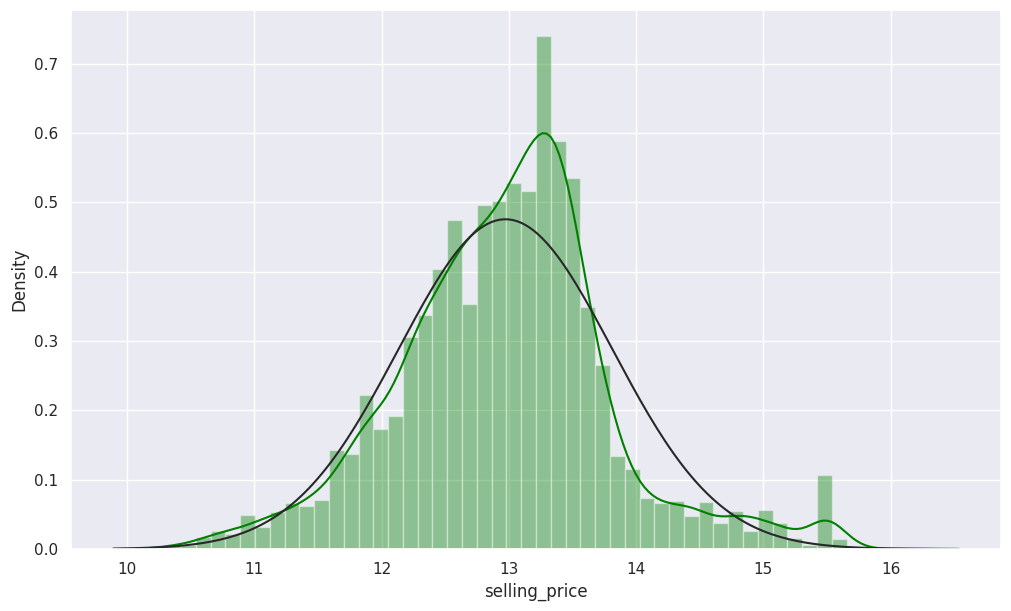

In [49]:
sns.distplot(df["selling_price"], fit = norm, color = "green");

In [50]:
numeric_data = [column for column in df.select_dtypes(["int", "float"])]
for col in numeric_data:
    print("Skewness of", col, "variable is:", df[col].skew())

Skewness of selling_price variable is: 0.22327004522860716
Skewness of km_driven variable is: 11.170909783549087
Skewness of mileage variable is: -0.14220847114521287
Skewness of engine variable is: 1.1753055440141613
Skewness of max_power variable is: 1.6595575154307947
Skewness of seats variable is: 2.015507247545297
Skewness of car_age variable is: 1.072292893616034


In [51]:
for c in numeric_data:
    df[c] = np.log1p(df[c])

In [52]:
df.head()

selling_price  km_driven    fuel seller_type transmission         owner  \
0       2.640271  11.887938  Diesel  Individual       Manual   First Owner   
1       2.626208  11.695255  Diesel  Individual       Manual  Second Owner   
2       2.562666  11.849405  Petrol  Individual       Manual   Third Owner   
3       2.589556  11.751950  Diesel  Individual       Manual   First Owner   
4       2.547513  11.695255  Petrol  Individual       Manual   First Owner   

    mileage    engine  max_power     seats car_brand_name   car_age  
0  3.194583  7.130099   4.317488  1.791759         Maruti  2.397895  
1  3.097386  7.312553   4.649378  1.791759          Skoda  2.397895  
2  2.928524  7.311886   4.369448  1.791759          Honda  2.944439  
3  3.178054  7.242082   4.510860  1.791759        Hyundai  2.708050  
4  2.839078  7.169350   4.490881  1.791759         Maruti  2.890372

In [53]:
y = df["selling_price"]

In [54]:
# select independent variable (estimator)
x = df.drop("selling_price", axis = 1)

#encode the variables of the dataset
x = pd.get_dummies(x, drop_first = True)

In [55]:
y.shape, x.shape

((8128,), (8128, 47))

In [56]:
x.head()

km_driven   mileage    engine  max_power     seats   car_age  fuel_Diesel  \
0  11.887938  3.194583  7.130099   4.317488  1.791759  2.397895         True   
1  11.695255  3.097386  7.312553   4.649378  1.791759  2.397895         True   
2  11.849405  2.928524  7.311886   4.369448  1.791759  2.944439        False   
3  11.751950  3.178054  7.242082   4.510860  1.791759  2.708050         True   
4  11.695255  2.839078  7.169350   4.490881  1.791759  2.890372        False   

   ...  car_brand_name_Peugeot  car_brand_name_Renault  car_brand_name_Skoda  \
0  ...                   False                   False                 False   
1  ...                   False                   False                  True   
2  ...                   False                   False                 False   
3  ...                   False                   False                 False   
4  ...                   False                   False                 False   

   car_brand_name_Tata  car_brand_name_Toyota  car_brand_name_Volkswagen  \
0                False                  False                      False   
1                False                  False                      False   
2                False                  False                      False   
3                False                  False                      False   
4                False                  False                      False   

   car_brand_name_Volvo  
0                 False  
1                 False  
2                 False  
3                 False  
4                 False  

[5 rows x 47 columns]

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.20,
                                                    shuffle = True,
                                                    random_state = 1)
print(x_train.shape)
print(x_test.shape)

(6502, 47)
(1626, 47)


In [58]:
rob_scaler = RobustScaler()
rob_scaler.fit(x_train)
x_train = rob_scaler.transform(x_train)
x_test = rob_scaler.transform(x_test)

In [59]:
k_fold = KFold(n_splits = 10, random_state = 11, shuffle = True)

In [60]:
def cv_rmse(model, X = x_train):
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring = "neg_mean_squared_error", cv = k_fold))
    return rmse

def rmsle(y, y_pred):
    rmsle = np.sqrt(mean_squared_log_error(y, y_pred, squared = False))
    return rmsle

In [61]:
xgb = XGBRegressor(n_estimators = 1000, random_state = 1)
lgbm = LGBMRegressor(n_estimators = 1000, random_state = 1)
gbr = GradientBoostingRegressor(n_estimators = 1000, random_state = 11)
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)
svr = SVR(C = 20)
lasso = LassoCV(alphas = [1e-10, 1e-8, 1e-7, 1e-5, 1e-2, 9e-4, 9e-3,
                                                        5e-4, 3e-4, 1e-4, 1e-3, 1e-2, 0.1,
                                                        0.3, 0.6, 1, 3, 5, 7, 14, 18, 25, 30,
                                                        45, 50, 70, 90], n_jobs = -1, cv = k_fold)

stacked = StackingCVRegressor(regressors = (xgb, lgbm, svr, lasso, gbr, rf),
                              meta_regressor = xgb, use_features_in_secondary = True)

In [62]:
stacked_model = stacked.fit(np.array(x_train), np.array(y_train))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 5201, number of used features: 35
[LightGBM] [Info] Start training from score 2.635737
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 899
[LightGBM] [Info] Number of data points in the train set: 5201, number of used features: 35
[LightGBM] [Info] Start training from score 2.635839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

In [63]:
stacked_score_train = rmsle(y_train, stacked_model.predict(x_train))
print("RMSLE score of stacked models on full train data:", stacked_score_train)

RMSLE score of stacked models on full train data: 0.05601120203941845


In [64]:
stacked_score_test = rmsle(y_test, stacked_model.predict(x_test))
print("RMSLE score of stacked models on full test data:", stacked_score_test)

RMSLE score of stacked models on full test data: 0.06721789278011303


In [65]:
y_pred = np.expm1(stacked_model.predict(x_test))
y_pred[0:5]

array([12.230317, 14.084409, 13.601036, 13.03639 , 12.435726],
      dtype=float32)

In [66]:
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared: {}'.format(metrics.r2_score(y_test, y_pred)))

Mean Absolute Error: 10.310679678436047
Mean Squared Error: 106.84320964475984
Root Mean Squared Error: 10.336498906533093
R-squared: -31447.766861241606


Text(0, 0.5, 'prediction')

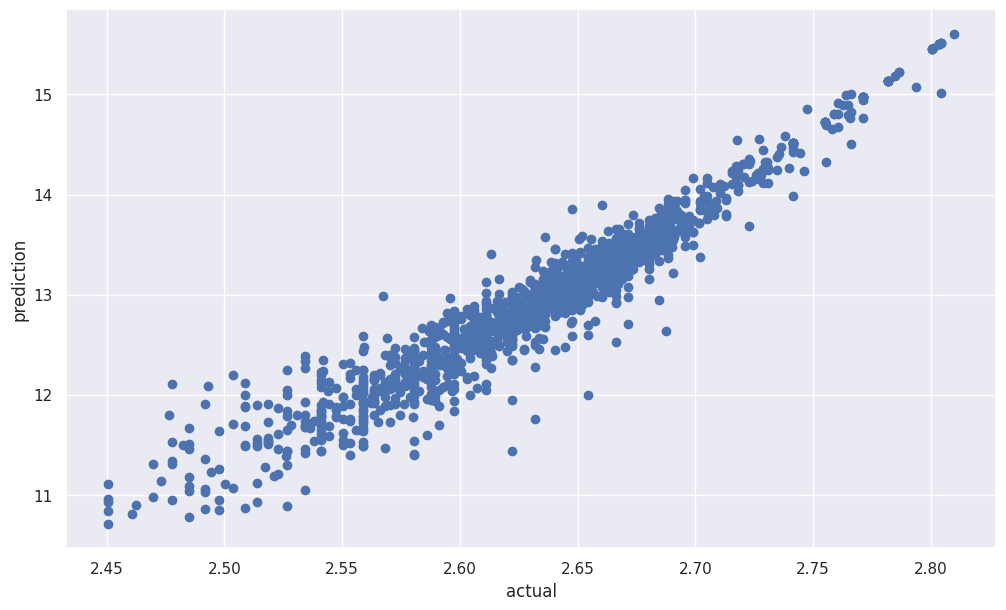

In [67]:
plt.scatter(y_test, y_pred);
plt.xlabel("actual")
plt.ylabel("prediction")